#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
# import julia;
# julia.install()

In [2]:
# TAKEAWAY: space derivative depend on nodes granularity. 
# Need increase number of nodes!

In [3]:
import numpy as np
import numdifftools as nd
import math
import matplotlib.pyplot as plt
from datetime import datetime
# from scipy.integrate import odeint
# from torchdiffeq import odeint
import torch
import inspect
import random

In [4]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [5]:
# from diffeqpy import ode
# from diffeqpy import de

In [6]:
from vehicles import shipClarke83
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [7]:
from sympy import *

In [8]:
def R2D(value):  # radians to degrees
    return value * 180 / math.pi

In [9]:
mp = 96 #  (submerged) [kg/m]

In [10]:
# # q0=[i for i in range(12)]
# max_t = 2 # 10 #600  
# dt = 0.5
# t=np.arange(0,max_t,dt)
# ds = 0.025
# print(t)

In [11]:
node_N=4

In [12]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
 
Irho=np.diag(diag_Irho)

In [13]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [14]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]

In [15]:
diag_DT = 1.5*np.array([1, 1, 1]) # [N/m]  , p.99 in [1]

In [16]:
DT=np.diag(diag_DT) # (35) in [2]

In [17]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [18]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]
# diag_CT = 1e10*np.array([1, 1, 1]) 

In [19]:
CT=np.diag(diag_CT)

In [20]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [21]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [22]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [23]:
rng = np.random.default_rng()

In [24]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [25]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
#     print(Re_t_(xyz[0]))
    return np.apply_along_axis(Re_t_, 1, xyz)

In [26]:
# φ, θ, ψ= np.zeros(node_N),np.zeros(node_N),np.zeros(node_N)

In [27]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[ 0.25622748,  0.04500285, -0.96556834],
       [ 0.90182211,  0.34843987,  0.25555145],
       [ 0.34794305, -0.93625018,  0.04869531]])

In [28]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.002040


In [29]:
Ret

array([[[ 0.25622748,  0.04500285, -0.96556834],
        [ 0.90182211,  0.34843987,  0.25555145],
        [ 0.34794305, -0.93625018,  0.04869531]],

       [[-0.04535674, -0.84996931,  0.52487612],
        [ 0.39025071, -0.49874214, -0.77392549],
        [ 0.91959075,  0.16973055,  0.35432245]],

       [[ 0.81081961,  0.50219479, -0.30061927],
        [-0.30330029, -0.07876714, -0.94963397],
        [-0.50058015,  0.86115976,  0.08844988]],

       [[-0.67713131, -0.24389158, -0.69426946],
        [-0.2776699 ,  0.95841575, -0.06586858],
        [ 0.68146358,  0.14817606, -0.71669466]]])

In [30]:
Ret.shape

(4, 3, 3)

In [31]:
# Dphi1, Dphi2, Dphi3 = symbols("Dphi1 Dphi2 Dphi3")
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [32]:
def C1(dx,dy,dz, Ret):
    B=np.vstack([dx**2,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
#     print(np.dot(Ret[0],B.T[0]))
    ans=np.einsum('ijk,ik->ij', Ret,B.T)
    return ans.T

In [33]:
dx**2

array([0.36559022, 1.3061357 , 0.52528947, 1.33895461])

In [34]:
C1(dx,dy,dz,Ret)

array([[ 0.10792887,  0.74839715, -1.42427143, -1.72787226],
       [ 0.30512036,  0.21919839,  1.41378349,  1.55180276],
       [ 0.18040765,  1.36423537, -4.21294699,  0.88023358]])

In [35]:
C1(dx,dy,dz,Ret).shape

(3, 4)

In [36]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000230


In [37]:
1/2*d0*qw*np.dot(DT,np.array([0.09,0.12727922, 0.12727922])) 

array([52.6516875 , 74.46073019, 74.46073019])

In [38]:
def fD(dx,dy,dz,DT,Ret):
#     print(dx)
#     print(C1(dx,dy,dz).shape) m2*kg/m3 N/m m2/s2*rad
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [39]:
fD(dx,dy,dz,DT,Ret)

array([[   619.40742205,   4295.07665156,  -8173.94209847,
         -9916.31755491],
       [  1751.09612546,   1257.98700719,   8113.75140567,
          8905.84872703],
       [  1035.36561972,   7829.39310582, -24178.24576449,
          5051.69036489]])

In [40]:
fD(dx,dy,dz,DT,Ret).T

array([[   619.40742205,   1751.09612546,   1035.36561972],
       [  4295.07665156,   1257.98700719,   7829.39310582],
       [ -8173.94209847,   8113.75140567, -24178.24576449],
       [ -9916.31755491,   8905.84872703,   5051.69036489]])

In [41]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000272


In [42]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [43]:
# Mat=np.matrix([[1.3,.4,6.7],[9,7,6],[3.3,5.6,7]])

In [44]:
I=np.identity(3)

In [45]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000225


In [46]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [47]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [48]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [49]:
DR=np.diag(diag_DR) 

In [50]:
dI= 0.69# Inner diameter of pipe, [m]

In [51]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [52]:
Ar

0.08091250419136858

In [53]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [54]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223]])

In [55]:
from numpy import linalg as LA

In [56]:
def k_sigma(hi,d0,fg_e):
    ans=[]
#     print('hi',hi)
    for it in hi:
#         print(it)
        if it<0:
            ans.append(0)
        elif 0<=it<=d0/20:
#             print(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0)
            ans.append(np.float64(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0))
        else:
#             print(LA.norm(fg_e,2)/(d0/8-d0/40)*10*hi**2/d0)
            ans.append(np.float64(LA.norm(fg_e,2)/(d0/8-d0/40)*(it-d0/40)))
#     print(ans)         
     
    return np.array(ans).reshape(node_N,1)   

In [57]:
x,y,z=np.array([2.3 for i in range(node_N)]),np.array([2.3 for i in range(node_N)]),np.array([2.3 for i in range(node_N)])

In [58]:
def hi(x,y,z,d0):
    return (np.dot(np.array([x,y,z]).T,[0,0,1])+d0/2).reshape(node_N,1) 

In [59]:
startTime1 = datetime.now()
hi(x,y,z,d0)
print(datetime.now() - startTime1)

0:00:00.000219


In [60]:
k_sigma(hi(x,y,z,d0),d0,fg_e)

array([[8964.69710988],
       [8964.69710988],
       [8964.69710988],
       [8964.69710988]])

In [61]:
startTime1 = datetime.now()
k_sigma(hi(x,y,z,d0),d0,fg_e)
print(datetime.now() - startTime1)

0:00:00.000924


In [62]:
# TODO: force shoud be acting only at nodes that are in contact with the seabed
def sigma(x,y,z):
    return (k_sigma(hi(x,y,z,d0),d0,fg_e)*np.array([0,0,1]))

In [63]:
startTime1 = datetime.now()
sigma(x,y,z)
print(datetime.now() - startTime1)

0:00:00.000473


In [64]:
# # angles should be in radians, otherwise np.radians them  
# def Re_t_(arr):
#     φ,θ,ψ=arr[0],arr[1],arr[2]
  
#     Cφ=np.matrix([[1,0,0],
#                       [0,np.cos(φ),-np.sin(φ)],
#                       [0,np.sin(φ),np.cos(φ)]])

#     Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
#                       [0,1,0],
#                       [-np.sin(θ),0,np.cos(θ)]])

#     Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
#                       [np.sin(ψ),np.cos(ψ),0],
#                       [0,0,1]])
        

#     return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [65]:
# Re_t_([1,2,3])

In [66]:
# φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [67]:
# def Re_t(a,b,c):
#     xyz=np.stack((a,b,c), axis=1)
# #     print(Re_t_(xyz[0]))
#     return np.apply_along_axis(Re_t_, 1, xyz)

In [68]:
# φ, θ, ψ

In [69]:
# Re_t_(np.array([φ[0], θ[0], ψ[0]]))

In [70]:
# startTime1 = datetime.now()
# Ret=Re_t(φ,θ,ψ)
# print(datetime.now() - startTime1)

In [71]:
# Ret

In [72]:
# vessel motion
# Fossen book p.101, p.190, p.384, p.431
# Fossen paper, section 6

In [73]:
# Fossen paper, equation (12)

In [74]:
# φ,θ,ψ=1,2,3

In [75]:
def Re_b(Ret):
    return np.dot(Ret, Rb_t ) # (5) in[3]

In [76]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000343


In [77]:
# p=np.dot(Re_b, phi) # (41) in[3]

In [78]:
# def d_s(da,db,dc,dt,ds):
    
def d_s(da,db,dc,x,y,z):
#     return np.vstack([da*dt/ds,db*dt/ds,dc*dt/ds])
#     print(np.diff(da))

    ds=np.sqrt(np.diff(x,prepend=x[0])**2+np.diff(y,prepend=y[0])**2
                 +np.diff(z,prepend=z[0])**2)
#     print(ds)
    ds[ds == 0] = 1
    return np.vstack([np.diff(da,prepend=da[0])/ds,np.diff(db,prepend=db[0])/ds,np.diff(dc,prepend=dc[0])/ds])

In [79]:
# a=[1,2,3]
# np.diff(a,prepend=a[0])

In [80]:
x,y,z=100*rng.standard_normal(node_N),100*rng.standard_normal(node_N),100*rng.standard_normal(node_N)


In [81]:
startTime1 = datetime.now()
d_s(x,y,z,x,y,z)
print(datetime.now() - startTime1)

0:00:00.000568


In [82]:
# φ,θ,ψ=np.array([2.3 for i in range(node_N)]),np.array([1.3 for i in range(node_N)]),np.array([2.1 for i in range(node_N)])


In [83]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [84]:
def ne(x,y,z,Ret):
#     print(np.multiply(Re_t(φ,θ,ψ),CT).shape)
#     print(np.multiply(np.multiply(Re_t(φ,θ,ψ),CT),
#                          Re_t(φ,θ,ψ)).shape)
#     print(d_s(dx,dy,dz,dt,ds).shape)
    
    A=np.multiply(np.multiply(Ret,CT),Ret)
#     B=d_s(dx,dy,dz,dt,ds).T
    B=d_s(x,y,z,x,y,z).T
    
#     print(A)
    
#     ans=[]
#     for i in range(len(A)):
#         ans.append(np.dot(A[i],B[i]))
    return np.einsum('ijk,ik->ij', A,B)
#     return np.array(ans)

In [85]:
def ne_(x,y,z,dx,dy,dz,Ret):
#     print('ho',fg_e.shape)
#     print(fD(dx,dy,dz,DT))
#     print(sigma(x,y,z))
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T
#     return -fg_e-fD(dx,dy,dz,DT)

In [86]:
sigma(x,y,z)

array([[     0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        , 557866.47421549],
       [     0.        ,      0.        , 195944.08996299]])

In [87]:
ne_(x,y,z,dx,dy,dz,Ret)

array([[ -619.40742205, -4295.07665156,  8173.94209847,  9916.31755491],
       [-1751.09612546, -1257.98700719, -8113.75140567, -8905.84872703],
       [-1163.53016195, -7957.55764805, 24050.08122226, -5179.85490712]])

In [88]:
# mp*ddp = d_s(ne,ds)+np.dot(Re_b,ne_)

In [89]:
startTime1 = datetime.now()
ne(x,y,z,Ret)
print(datetime.now() - startTime1)

0:00:00.001033


In [90]:
startTime1 = datetime.now()
ne_(x,y,z,dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000256


In [91]:
Re_b(Ret).shape

(4, 3, 3)

In [92]:
def Irho_e(Ret):
    return np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 

In [93]:
Irho_e(Ret)

array([[[  6.56525227,   0.        ,   0.        ],
        [  0.        ,  12.14103413,   0.        ],
        [  0.        ,   0.        ,   0.47424661]],

       [[  0.20572338,   0.        ,   0.        ],
        [  0.        ,  24.87437216,   0.        ],
        [  0.        ,   0.        ,  25.10887909]],

       [[ 65.74284469,   0.        ,   0.        ],
        [  0.        ,   0.62042623,   0.        ],
        [  0.        ,   0.        ,   1.56467641]],

       [[ 45.85068106,   0.        ,   0.        ],
        [  0.        ,  91.85607541,   0.        ],
        [  0.        ,   0.        , 102.73024855]]])

In [94]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000226


In [95]:
# def Π_(arr):
#     φ,θ,ψ=arr[0],arr[1],arr[2]
#     return np.array([[np.cos(θ)*np.cos(ψ),-np.sin(ψ),0],
#                   [np.cos(θ)*np.sin(ψ),np.cos(ψ),0],
#                   [-np.sin(θ),0,1]])
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [96]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [97]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.002475


In [98]:
def ωe(φ,θ,ψ,x,y,z):  # (100) in [2]
    A=Π(φ,θ,ψ)
#     print(A)
#     B=np.array([φ,θ,ψ]).T
    B=d_s(φ,θ,ψ,x,y,z).T
#     print(B)
#     ans=[]
#     for i in range(len(A)):
#         ans.append(np.dot(A[i],B[i]))
    return np.einsum('ijk,ik->ij', A,B)    
#     return np.array(ans) 
#     ans=[]
#     for i in range(len(φ)):
#         ans.append(np.dot(Π(φ[i],θ[i],ψ[i]),np.array([φ[i],θ[i],ψ[i]])))  # (100) in [2]
#     return np.vstack(ans)    

In [99]:
# np.dot(np.matrix([[-0.13504574, -0.86320937,  0.        ],
#   [ 0.23090749, -0.5048461 ,  0.        ],
#   [-0.96355819,  0.,          1.        ]]),np.array([2.3, 1.3, 2.1]))

In [100]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,x,y,z)
print(datetime.now() - startTime1)

0:00:00.001744


In [101]:
diag_CR = 1e11*np.array([1, 1, 1]) 
# diag_CR = 1e7*np.array([1, 1, 1]) 
CR=np.diag(diag_CR)

In [102]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [103]:
def me(φ,θ,ψ,x,y,z,Ret):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=ωe(φ,θ,ψ,x,y,z)
    ans=[]
    return np.einsum('ijk,ik->ij', A,B) 
#     for i in range(len(A)):
#         ans.append(np.dot(A[i],B[i]))
#     return np.array(ans)
#     tmp=[]
#     for i in range(len(φ)):
#         tmp.append(np.dot(np.dot(Re_t(φ[i],θ[i],ψ[i]),CR),Re_t(φ[i],θ[i],ψ[i]).T))
        
#     tmp1= ωe(φ,θ,ψ)
    
#     ans=[]
#     for i in range(len(tmp1)):
#         ans.append(np.dot(np.array(tmp[i]),tmp1[i] ))
#     return np.array(ans).reshape(3,-1)

In [104]:
startTime1 = datetime.now()
me_=me(φ,θ,ψ,x,y,z,Ret)
print(datetime.now() - startTime1)

0:00:00.003191


In [105]:
me_

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.79373207e+06,  1.92374445e+07, -2.96235411e+07],
       [ 8.87750275e+07,  2.87866235e+06, -2.53422682e+05],
       [ 3.48449414e+08, -1.45225149e+09, -4.91025630e+08]])

In [106]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [107]:
# np.dot(Re_b, np.dot( Irho_e, (np.dot(Π(φ,θ,ψ), np.array([ddφ,ddθ,ddψ])))))=
# -np.dot(Re_b,np.dot(Irho_e,np.dot(Π(dφ,dθ,dψ),np.array([dφ,dθ,dψ])))-
# np.cross(np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ])),np.dot(Irho_e, np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))+
# np.dot(Re_b,d_s(me_[0],me_[1],me_[2],dt,ds)+d_s(me_[0],me_[1],me_[2],dt,ds))+
# np.cross(d_s(x,y,z,dt,ds),ne(x,y,z,φ,θ,ψ,dt,ds))+
# np.dot(Re_b,-np.dot(DR,np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))

In [108]:
ne_(x,y,z,dx,dy,dz,Ret)

array([[ -619.40742205, -4295.07665156,  8173.94209847,  9916.31755491],
       [-1751.09612546, -1257.98700719, -8113.75140567, -8905.84872703],
       [-1163.53016195, -7957.55764805, 24050.08122226, -5179.85490712]])

In [109]:
C=ne(x,y,z,Ret)
  
a,b,c=C[:,0],C[:,1],C[:,2]

In [110]:
d_s(a,b,c,x,y,z)

array([[ 0.00000000e+00, -1.68571574e+03,  6.38249223e+05,
        -2.25112552e+05],
       [ 0.00000000e+00, -8.23867976e+05,  8.60744680e+05,
         3.18420143e+06],
       [ 0.00000000e+00, -4.54701230e+04,  6.94838067e+04,
        -3.33280129e+06]])

In [111]:
Re_b(Ret).shape

(4, 3, 3)

In [112]:
ne_(x,y,z,dx,dy,dz,Ret).T

array([[ -619.40742205, -1751.09612546, -1163.53016195],
       [-4295.07665156, -1257.98700719, -7957.55764805],
       [ 8173.94209847, -8113.75140567, 24050.08122226],
       [ 9916.31755491, -8905.84872703, -5179.85490712]])

In [113]:
type(x),y,z,dx,type(dy),dz

(numpy.ndarray,
 array([  57.36281246, -223.97541614,  -80.18545944,  -21.47327457]),
 array([-34.67525237, -65.43990767, 165.26014682,  57.81118722]),
 array([ 0.60464057,  1.14286294, -0.72476857, -1.15713206]),
 numpy.ndarray,
 array([-0.07106881,  0.75591167, -0.59770033,  0.32256992]))

In [114]:
ne_(x,y,z,dx,dy,dz,Ret).T+np.einsum('ijk,ik->ij', Re_b(Ret),ne_(x,y,z,dx,dy,dz,Ret).T)

array([[   266.54695203,  -3217.18495903,    203.75693738],
       [ -7207.74765574,   3851.824067  , -14940.33051293],
       [  3496.93306717, -32792.58747038,  15098.35875604],
       [  8969.94505317, -19853.6276858 ,   3970.49520723]])

In [115]:
ne_(x,y,z,dx,dy,dz,Ret).T

array([[ -619.40742205, -1751.09612546, -1163.53016195],
       [-4295.07665156, -1257.98700719, -7957.55764805],
       [ 8173.94209847, -8113.75140567, 24050.08122226],
       [ 9916.31755491, -8905.84872703, -5179.85490712]])

### Catenary

In [116]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [117]:
pipe_weight_per_unit_length = mp #  (submerged) [kg/m]  # 113.07 - not submerged

In [118]:
Fx_0=82945396

In [119]:
Ws = pipe_weight_per_unit_length*9.81 # [N/m]
h=700

In [120]:
S=math.sqrt(h*(2*Fx_0/Ws -h))
horizontal_length=(Fx_0/Ws -h)*np.log((S+Fx_0/Ws)/(Fx_0/Ws-h))

In [121]:
delta_x=horizontal_length/(node_N-1)

In [122]:
x0=[i*delta_x for i in range(node_N)]
z0=[]
for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws,Fx_0))

In [123]:
x0,z0

([0.0, 3684.228281487207, 7368.456562974414, 11052.68484446162],
 [0.0, 77.06804644731459, 308.40705929683963, 694.4218951076863])

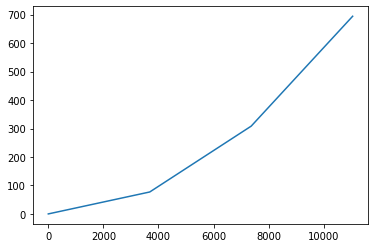

In [124]:
plt.plot(x0, z0)
plt.show()

In [125]:
rng = np.random.default_rng()
q0=np.zeros(12*node_N)

In [126]:

for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0
# #     elif j==7 or j==9 or j==11: 
#     elif j==9 or j==11: 
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
# #         q0[(j-1)*node_N:j*node_N]=np.array([0.01 for x in range(node_N)])

In [127]:
q0

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [128]:
q0[node_N*6]=0

In [129]:
q0[node_N*8]=0

In [130]:
q0[node_N*10]=0

### Vessel

In [131]:
class VesselSemisub: # Semisub model from Fossen
    
    def __init__(self):
        
        MRB = 1.0e10 * np.array(
            [
                [0.0027, 0, 0, 0, -0.0530, 0],
                [0, 0.0027, 0, 0.0530, 0, -0.0014],
                [0, 0, 0.0027, 0, 0.0014, 0],
                [0, 0.0530, 0, 3.4775, 0, -0.0265],
                [-0.0530, 0, 0.0014, 0, 3.8150, 0],
                [0, -0.0014, 0, -0.0265, 0, 3.7192],
            ],
            float,
        )

        MA = 1.0e10 * np.array(
            [
                [0.0017, 0, 0, 0, -0.0255, 0],
                [0, 0.0042, 0, 0.0365, 0, 0],
                [0, 0, 0.0021, 0, 0, 0],
                [0, 0.0365, 0, 1.3416, 0, 0],
                [-0.0255, 0, 0, 0, 2.2267, 0],
                [0, 0, 0, 0, 0, 3.2049],
            ],
            float,
        )

        self.D = 1.0e09 * np.array(
            [
                [0.0004, 0, 0, 0, -0.0085, 0],
                [0, 0.0003, 0, 0.0067, 0, -0.0002],
                [0, 0, 0.0034, 0, 0.0017, 0],
                [0, 0.0067, 0, 4.8841, 0, -0.0034],
                [-0.0085, 0, 0.0017, 0, 7.1383, 0],
                [0, -0.0002, 0, -0.0034, 0, 0.8656],
            ],
            float,
        )

#         self.G = 1.0e10 * np.diag([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.G =1.0e10 *np.array([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.M = MRB + MA
#         print(self.G,self.M)


    def tau(self,η, dη, ddη):
        φ,θ,ψ=η[3:]
        Ret=Re_t_([φ,θ,ψ])
        A=Re_b(Ret)
#         print(Π_([φ,θ,ψ]))
#         print(Re_b(Ret))
        B=np.dot(np.linalg.inv(Π_([φ,θ,ψ])),Re_b(Ret))
        Z=np.zeros((3,3))
        C0=np.concatenate([A,Z],axis=1)
        C1=np.concatenate([Z,B],axis=1)
        C=np.concatenate([C0,C1],axis=0)
#         print(np.dot(C,self.G))
#         print(np.matmul(self.M,ddη))
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.dot(C,self.G))
#         return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + self.G)/10000000

In [132]:
V=VesselSemisub()

In [133]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [134]:
tau_force = V.tau(η,dη, ddη)

In [135]:
tau_force

array([ 3.38785484e+06, -2.37412183e+06,  4.34580086e+06, -1.36399445e+10,
        3.02038732e+10,  1.28049082e+10])

In [136]:
np.matmul(np.array([[1.1,1.2],[1,2]]),np.array([1,2]))

array([3.5, 5. ])

In [137]:
sampleTime = 1e-5                # sample time [seconds]
N = int(2e5)                         # number of samples

In [138]:
N

200000

In [139]:
vehicle_1=semisub('DPcontrol',0.,5.,30.0,0,0) 

In [140]:
[simTime_1, simData_1] = simulate(N, sampleTime, vehicle_1)

In [141]:
# vehicle_2=semisub('DPcontrol',0.,-5.,30.0,0,0) 

In [142]:
# [simTime_2, simData_2] = simulate(N, sampleTime, vehicle_2)

In [143]:
simData_1.shape

(200001, 24)

In [144]:
# simData=np.concatenate([simData_1,simData_2], axis=0)
simData=simData_1

In [145]:
simData.shape

(200001, 24)

In [146]:
# ans_t = simTime_1

In [147]:
simData[250]

array([-7.60552768e-28,  4.82445838e-13, -2.13685613e-27, -8.93579126e-15,
        2.26440987e-29,  4.31798415e-15,  7.05412312e-25,  7.67014558e-10,
       -2.67330488e-27, -1.42063658e-11,  9.16569250e-27,  6.86493499e-12,
        2.09373441e+02,  1.99173298e+02,  4.05331096e+02,  3.66779677e+02,
       -3.54838043e+02,  3.54838043e+02,  5.22778100e-01,  4.97309624e-01,
        1.01205782e+00,  9.15799671e-01, -8.85985068e-01,  8.85985068e-01])

In [148]:
simData.shape

(200001, 24)

In [149]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

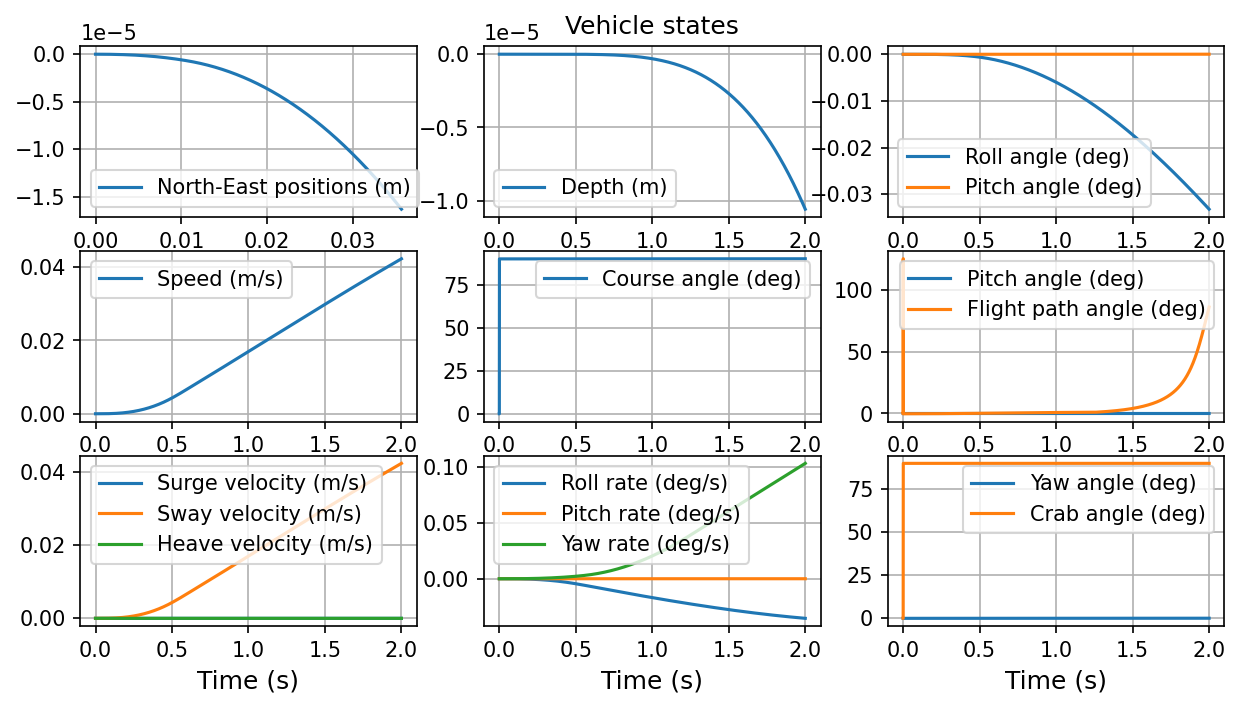

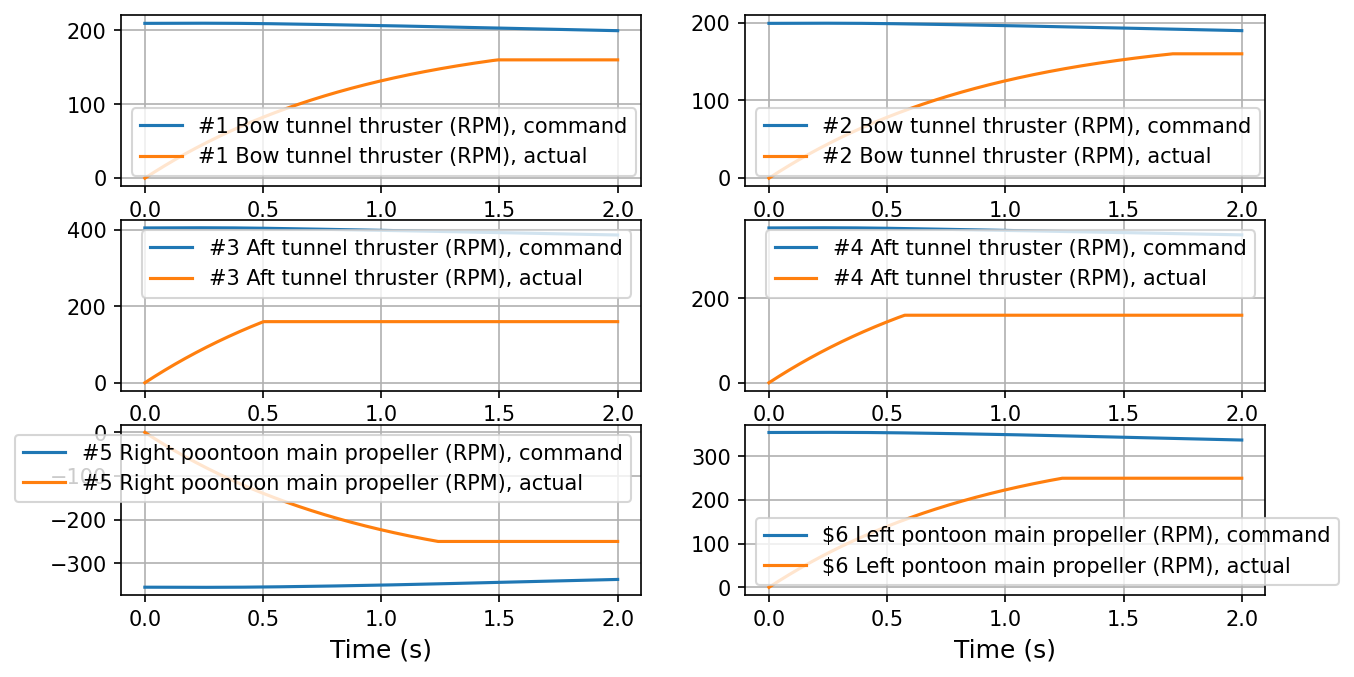

In [150]:
plotVehicleStates(simTime_1, simData_1, 1)                    
plotControls(simTime_1, simData_1, vehicle_1, 2)

In [151]:
# plotVehicleStates(simTime_2, simData_2, 1)                    
# plotControls(simTime_2, simData_2, vehicle_2, 2)

In [152]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'                  # browser for visualization of animated GIF

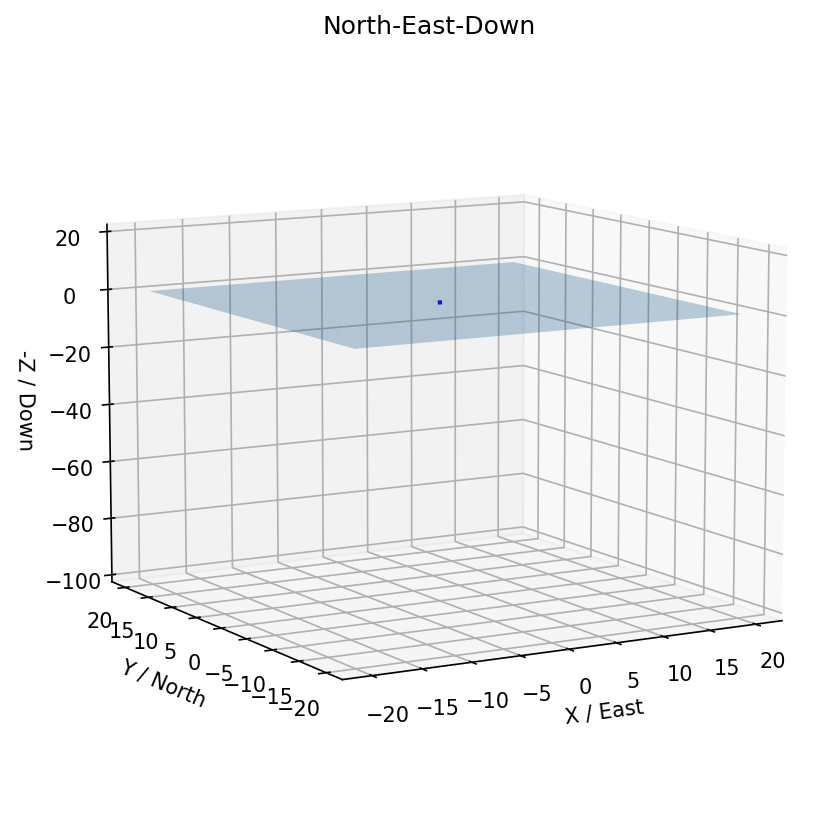

In [153]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

### Modelling

In [154]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [155]:
# simData[1]

In [156]:
simD_1=np.insert(simData_1, 0, simData_1[0], axis=0)
# simD_2=np.insert(simData_2, 0, simData_2[0], axis=0)

In [157]:
diff_1=np.diff(simD_1,axis=0)
# diff_2=np.diff(simD_2,axis=0)

In [158]:
# diff=np.concatenate([diff_1,diff_2], axis=0)

In [159]:
diff=diff_1

In [160]:
V=VesselSemisub()

In [161]:
# thres =0.1

In [162]:
def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

In [163]:
# simD=np.concatenate([simD_1,simD_2], axis=0)

In [164]:
simD = simD_1

In [165]:
SD0=simD[:, 0]
SD1=simD[:, 1]
SD2=simD[:, 2]
SD3=simD[:, 3]
SD4=simD[:, 4]
SD5=simD[:, 5]
SD6=simD[:, 6]
SD7=simD[:, 7]
SD8=simD[:, 8]
SD9=simD[:, 9]
SD10=simD[:, 10]
SD11=simD[:, 11]
Diff6=diff[:, 6]
Diff7=diff[:, 7]
Diff8=diff[:, 8]
Diff9=diff[:, 9]
Diff10=diff[:, 10]
Diff11=diff[:, 11]

In [166]:
# def feedback(Q):
#     x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
#     dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
#     φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
#     dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]

#     K = 2e6 # feedback gain
#     u_x = -K * x 
#     u_y = -K * y
#     u_z = -K * z 
#     u_dx = -K * dx 
#     u_dy = -K * dy 
#     u_dz = -K * dz 
#     u_φ = -K * φ 
#     u_θ = -K * θ
#     u_ψ = -K * ψ 
#     u_dφ= -K * dφ 
#     u_dθ = -K * dθ 
#     u_dψ = -K * dψ 
#     return np.concatenate([u_x, u_dx, u_y, u_dy, u_z, u_dz, u_φ, u_dφ, u_θ, u_dθ, u_ψ, u_dψ], axis=0) 

In [167]:
# def Jv(x, y, z):
    
#     def Jv0(k,x0,x1,y0,y1,z0,z1):
#         tmp1=(x0+x1)/2 
#         tmp2=(y0+y1)/2
#         tmp3=(z0+z1)/2 
#         return np.array([tmp1, tmp2, tmp3]).T 
# #         else:
# #             return np.array([0, 0, 0]).T 
    
#     ans=np.array([Jv0(k, x[k-1],x[k], y[k-1], y[k], z[k-1], z[k]) for k in range(1,node_N)])
    
#     return np.concatenate([ans,np.array([0, 0, 0]).reshape(3,1).T], axis=0).T

In [168]:
# x, y, z = q0[0:node_N],q0[2*node_N:3*node_N],q0[4*node_N:5*node_N]

In [169]:
# q0

In [170]:
# Jv(x, y, z )

In [171]:
# class Time:
#     def __init__(self):
#         self.time=1
# # #         self.n=1
# # # #         self.my_max = sampleTime*N*2
# #         self.my_time=0
# # # #         self.my_n=0
# #         self.my_update=up

In [172]:
# co=Time()

In [173]:
def asymptote(t):
    return t/np.sqrt(t**2+1)

In [174]:
from scipy.integrate import solve_ivp

In [175]:
# def grayscott1d(Q,p,t):
def grayscott1d(t, Q):
#     Q,t=np.array(Q),np.array(t)
    print(t)
#     dt=0
#     dt=abs(t-co.time)
#     print('dt',t,co.time,dt)
#     co.time+=sampleTime
  
#     if co.my_time%co.my_max==0:
#         co.my_n+=1
        
#     co.my_time+=co.my_update     
    
#     print(Q)   
#     print(abs(co.my_time))
    
#     idx = find_nearest(ans_t,  co.my_time%len(ans_t)) #!!!!!!!!!!!!!!!!!!!!!
#     print(idx)
    idx = find_nearest(ans_t,  t%len(ans_t)) 
    print('idx',idx)
#     print(t)
#     print(idx)
#     ind=ans_t.index(val)
    # State vectors
    x_ve = SD0[idx]
    y_ve = SD1[idx]
    z_ve = SD2[idx]
#     print(x_ve,y_ve,z_ve)
#     phi_ve = R2D(ssa(SD3[idx]))
#     theta_ve = R2D(ssa(SD4[idx]))
#     psi_v = R2D(ssa(SD5[idx]))
    phi_ve = ssa(SD3[idx])
    theta_ve = ssa(SD4[idx])
    psi_v = ssa(SD5[idx])
#     phi_ve = SD3[idx]
#     theta_ve = SD4[idx]
#     psi_v = SD5[idx]
    u_ve = SD6[idx]
    v_ve = SD7[idx]
    w_ve = SD8[idx]
#     p_ve = SD9[idx]
#     q_ve = SD10[idx]
#     r_ve = SD11[idx]
    p_ve = ssa(SD9[idx])
    q_ve = ssa(SD10[idx])
    r_ve = ssa(SD11[idx])
    
    
#     print(t-co.time)
    du_ve = Diff6[idx]/sampleTime
    dv_ve = Diff7[idx]/sampleTime
    dw_ve = Diff8[idx]/sampleTime
    dp_ve = Diff9[idx]/sampleTime
    dq_ve = Diff10[idx]/sampleTime
    dr_ve = Diff11[idx]/sampleTime
#     print(u_ve, dr_ve )
    
#     co.time=t
#     co.n+=1
#     print(co.time)
    η=np.array([ x_ve, y_ve, z_ve,phi_ve, theta_ve,  psi_v])
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    ddη=np.array([du_ve, dv_ve, dw_ve, dp_ve, dq_ve, dr_ve])
#     print( dη)
#     print(ddη)
    
#     tau_force = V.tau(η,dη, ddη)*asymptote(t)
    tau_force = V.tau(η,dη, ddη)
#     co.time += 1
    print(tau_force )
#     print()
    
    
    
    
#     p_ve = R2D(simData[:, 9][idx])
#     q_ve = R2D(simData[:, 10][idx])
#     r_ve = R2D(simData[:, 11][idx])

#     if t>dt*co.count:
#         co.count+=1
        
#     print(type(Q))
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
#     print(x0[-1],y0[-1])

#     x[-1]=x_ve+x0[-1]
#     y[-1]=y_ve
#     z[-1]=z_ve+z0[-1]

#     print( x[-1], y[-1], z[-1])
    x[0]=0
    y[0]=0
    z[0]=0
#     print(z)
#     print(z_ve)
#     print(x_ve,y_ve,z_ve)
#     print(x[0],y[0],z[0])
#     print(x[-1],y[-1],z[-1])
#     print()
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    
    dx[0]=0
    dy[0]=0
    dz[0]=0
    
    
#     dx[-1]=u_ve
#     dy[-1]=v_ve 
#     dz[-1]=w_ve
#     print(dx,dy.shape, dx.shape)
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)
#     print(Ret)
    
#     φ[-1]=phi_ve
#     θ[-1]=theta_ve
#     ψ[-1]=psi_v
    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
#     dφ[-1]=p_ve
#     dθ[-1]= q_ve
#     dψ[-1]=r_ve
#     print(z)    
#     print(t)
    
#     ddx = np.empty_like(y)
#     ddy = np.empty_like(y)
#     ddz = np.empty_like(y)
#     ddφ = np.empty_like(y)
#     ddθ = np.empty_like(y)
#     ddψ= np.empty_like(y)
    C=ne(x,y,z,Ret)
#     print('C',C)
  
    a,b,c=C[:,0],C[:,1],C[:,2]
#     print('abc',a,b,c)
#     print(a,C)
#     print(a)
    
#     for it in [φ,θ,ψ,x,y,z,dx,dy,dz]:
#         print(it)
    # here single Re_b(φ,θ,ψ) etc.
#     print(np.einsum('ijk,ik->ij', Re_b(φ,θ,ψ).astype(float), ne_(x,y,z,dx,dy,dz).astype(float).T))
#     print(ne_(x,y,z,dx,dy,dz).astype(float))
#     Z0=np.zeros((node_N,3))
#     print(tau_force[:3].shape)
#     Z0[-1]=tau_force[:3]
#     print(Z0)
#     Z0=np.dot(Jv(x, y, z ).T,tau_force[:3]).reshape(node_N,1)
#     print(Z0)
#     print()
#     Z0=np.dot(Re_b(Ret),tau_force[:3])
    Z0=tau_force[:3]
#     print(Z0)
#     Z0=tau_force[:3].T
#     print(Z0)
    Z1 = d_s(a,b,c,x,y,z).T
#     print(Z1.shape)
#     Z2 =np.einsum('ijk,ik->ij', Re_b(Ret), ne_(x,y,z,dx,dy,dz,Ret).T)
#     print(Z1,Z2)
    Z2=ne_(x,y,z,dx,dy,dz,Ret).T
#     print(Z0)
#     Z=(np.einsum('ijk,ik->ij', Re_b(Ret), Z1 + Z2) 
    Z= ( Z1 + Z2 
        - Z0 
       )
#     print(Z1,Z2, - Z0,Z)
#     print()
#     print(Z0,Z1,Z2)
#     print(Z)
    
    
#     if np.isnan(np.sum(Z0)):
#         print('Z0 NaN',np.isnan(np.sum(Z0)))
#     if max(abs(np.amax(Z0)), abs(np.amin(Z0)))>thres :
#         print('Z0', Z0) 
                  
#     if np.isnan(np.sum(Z1)):
#         print('Z1 NaN',np.isnan(np.sum(Z1)))
#     if max(abs(np.amax(Z1)), abs(np.amin(Z1)))>thres :
#         print('Z1', Z1)    
                  
#     if np.isnan(np.sum(Z2)):
#         print('Z2 NaN',np.isnan(np.sum(Z2)))
#     if max(abs(np.amax(Z2)), abs(np.amin(Z2)))>thres :
#         print('Z2', Z2)      
#     print(Z.shape)
    
    
    ddx,ddy, ddz = 1/Ws*np.linalg.solve(Re_b(Ret),Z).T 
    
#     print(ddx,ddy, ddz)
#     print(ddx,ddy, ddz)
#     print('ddx',ddx)  
#     print('ddy',ddy) 
#     print('ddz',ddz) 
    
    me_=me(φ,θ,ψ,x,y,z,Ret)
#     print(Re_b(φ,θ,ψ).shape)
#     print(Irho_e(φ,θ,ψ).shape)
#     print(Irho_e(φ,θ,ψ).shape)

    
#     C1=np.einsum('ijk,ik->ij', Re_b(Ret).astype(np.float32), np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
#                                                         np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
#                                                                   np.array([dφ,dθ,dψ]).astype(np.float32).T)))
    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float32).T))
    
    C2= np.cross(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T),
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                           np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))
    
#     print(Re_b(φ,θ,ψ).shape)
# #     print(me_)
# #     print(me_[:,0])
#     print(d_s(me_[:,0],me_[:,1],me_[:,2],dt,ds).shape)
# #     print(Irho_e(φ,θ,ψ).shape)
#     print(d_s(me_[:,0],me_[:,1],me_[:, 2],dt,ds))
#     print(me_)
#     print('d_s',d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z))
#     C3= np.einsum('ijk,ik->ij',Re_b(Ret).astype(np.float32),d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T)
    C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T
#     C3=np.einsum('ijk,ik->ij', Re_b(Ret),C3_)
#     print(C3.shape)
#     print(d_s(x,y,z,dt,ds).shape)
#     print(ne(x,y,z,φ,θ,ψ,dt,ds).T.shape)
    C4= np.cross(d_s(x,y,z,x,y,z).T,ne(x,y,z,Ret))
#     print(np.dot(DR,K).shape)
#     print(Re_b(φ,θ,ψ).shape)
#     print(np.dot(DR,K[:,0]))

    K1=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T).T
#     print('K1',np.array([dφ,dθ,dψ]))
#     C5= np.einsum('ijk,ik->ij',Re_b(Ret).astype(np.float32),-np.dot(DR,K1).astype(np.float32).T)
    C5= -np.dot(DR,K1).astype(np.float32).T
#     if np.isnan(np.sum(C1)):
#         print('C1',np.isnan(np.sum(C1)))
#     if np.isnan(np.sum(C2)):    
#         print('C2',np.isnan(np.sum(C2)))
#     if np.isnan(np.sum(C3)):    
#         print('C3',np.isnan(np.sum(C3)))
#     if np.isnan(np.sum(C4)):    
#         print('C4',np.isnan(np.sum(C4)))
#     if np.isnan(np.sum(C5)):    
#         print('C5',np.isnan(np.sum(C5)))
#     print(C5.shape)    
#     C0=np.zeros((node_N,3))
#     C0[-1]=tau_force[3:]
#     print(Π(φ,θ,ψ).shape)
#     print(Re_b(Ret).shape)
#     print(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ)),Re_b(Ret)).shape)
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
#     print(tau_force[3:])
#     print(C0.shape)
#     .reshape(node_N,3)
#     print(np.einsum('ijk,ikr->ijr',Π(φ,θ,ψ),Re_b(Ret)).shape)
#     if np.isnan(np.sum(C0)):
#         print('C0',np.isnan(np.sum(C0)))
#     for a in [C1,C2,C3,C4,C5,C0]:   
#         if max(abs(np.amax(a)), abs(np.amin(a)))>thres :
#             print('{}'.format( retrieve_name(a)),a)
    
    B_ =(-C1-C2+C3+C4+C5)
    B=(np.einsum('ijk,ik->ij', Re_b(Ret), B_)
       -C0.squeeze()
      )
#     print(B.shape,C0.squeeze().shape)
#     print(B.shape)
#     print(C0, C0.squeeze())
#     print(B)
#     print(B.shape)
#     print(Re_b(φ,θ,ψ).shape)
#     print(Irho_e(φ,θ,ψ).shape)
#     print(Π(φ,θ,ψ).shape)
#     A1 =Re_b(Ret).astype(np.float32)
    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
#     print(np.einsum('ijk,ijk->ijk',A1,A2))
#     print('A1',A1)
#     print(A1)
#     print('bu',A1[0])
#     print('hey', np.dot(A1[0],A2[0]))
#     print('op', np.einsum('ijk,ikr->ijr',A1,A2))
#     print(Π(φ,θ,ψ).shape)
#     A=np.einsum('ijk,ikr->ijr',np.einsum('ijk,ikr->ijr',A1,A2),A3)
    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     print(B,A)    
#     if np.isnan(np.sum(A)):     
#         print('A',np.isnan(np.sum(A)))
      
#     if max(abs(np.amax(A)), abs(np.amin(A)))>thres :
#         print('A', A)   
   

#     if np.isnan(np.sum(B)):     
#         print('B',np.isnan(np.sum(B)))
      
#     if max(abs(np.amax(B)), abs(np.amin(B)))>thres :
#         print('B', B)  
#     print(A)
#     print()
#     print()


#     print(A.shape)
#     print(B.shape)
#     print(np.linalg.solve(A,B) ) 

#     print(A.shape,B.shape)
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T 
#     ddφ,ddθ,ddψ = torch.linalg.lstsq(torch.from_numpy(A.astype(np.float64)),torch.from_numpy(B.astype(np.float64))).solution.cpu().numpy().T
    
#     test1 = np.concatenate([ddφ,ddθ,ddψ])
    
#     if np.isnan(np.sum(test1)):     
#         print('test1 NaN',np.isnan(np.sum(test1)))
      
#     if max(abs(np.amax(test1)), abs(np.amin(test1)))>thres :
#         print('test1', test1)
#     torch.from_numpy(A),torch.from_numpy(B))
#     ans_φ=[]
#     ans_θ=[]
#     ans_ψ=[]
#     for i in range(len(A)):
#         a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
#         ans_φ.append(a)
#         ans_θ.append(b)
#         ans_ψ.append(c)
    
# #     print(ans_ψ)

#     ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#     ddφ,ddθ,ddψ =np.linalg.lstsq(A,B,rcond=-1).T 
#     ddφ,ddθ,ddψ =torch.linalg.tensorsolve(torch.from_numpy(A),torch.from_numpy(B)).T
#     print(ddφ)
#     print(np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ]))
    
    # is it the right order ?
#     print('dx',dx)
#     print('dy',dy)
#     print('dz',dz)
    
#     A1111=np.concatenate(np.stack([dx,ddx, dy, ddy, dz, ddz dφ, dθ, dψ, , ddy, ddφ, ddθ, ddψ], axis=0).T) 
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0) 
#     if np.isnan(np.sum(A1111)): 
#         print('A1111 NaN',np.isnan(np.sum(A1111)))
#     if np.amax(A1111)>thres :
#         print('A1111', A1111)  
        
        
#     print(A1111)
#     print(A1111)
    
#     print(A)
#     print()
#     print(A1111)
#     print(A1111)
#     return torch.from_numpy(A1111)

#     return A1111+feedback(Q)
#     print(φ,θ,ψ)
#     print(Ret)
#     if np.isnan(np.sum(φ)):     
#         print('φ',np.isnan(np.sum(φ)))
#     if np.isnan(np.sum(θ)):     
#         print('θ',np.isnan(np.sum(θ)))
#     if np.isnan(np.sum(ψ)):     
#         print('ψ',np.isnan(np.sum(ψ))) 
#     print(A1111)
    return A1111

In [176]:
# q0[7*node_N:8*node_N],q0[9*node_N:10*node_N],q0[11*node_N:12*node_N]

In [177]:
# for i in range(1000):
#     Q1111=100*rng.standard_normal(12*node_N)
#     print(grayscott1d(Q1111, 0.1, simData))

In [178]:
# q0.shape

In [179]:
# import numpy as np

In [180]:
# np.concatenate([np.array([0,3,6]),np.array([1,4,7]),np.array([2,5,8])], axis=0)

In [181]:
# # q0=[i for i in range(12)]
# max_t =2 #0.1 # 10 #600  
# dt = 0.5
# t=np.arange(0,max_t,dt)
# # ds = 0.025
# print(t)

In [182]:
# grayscott1d(4,q0)

In [183]:
# grayscott1d(4,q0).shape

In [184]:
# # q0=[i for i in range(12)]
# max_t = 2 # 10 #600  
# dt = 0.5
# t=np.arange(0,max_t,dt)
# ds = 0.025
# print(t)

In [185]:
import scipy

In [186]:
# ode15s = scipy.integrate.ode(grayscott1d)
# ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# # ode15s.set_integrator('vode',  order=15, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [187]:
tspan = (0., 2)

In [188]:
q0

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [189]:
startTime1 = datetime.now()
# prob = de.ODEProblem(grayscott1d, q0, tspan)
# us = de.solve(prob)
us=solve_ivp(grayscott1d,  tspan, q0, method='BDF',rtol=1, atol=1)
# us=ode15s.integrate(3)
print(datetime.now() - startTime1)

0.0
idx 0
[0.0000e+00 0.0000e+00 6.0000e+06 1.4296e+10 2.6212e+10 0.0000e+00]
4.08977836632201e-11
idx 0
[0.0000e+00 0.0000e+00 6.0000e+06 1.4296e+10 2.6212e+10 0.0000e+00]
0.0
idx 0
[0.0000e+00 0.0000e+00 6.0000e+06 1.4296e+10 2.6212e+10 0.0000e+00]
0.0
idx 0
[0.0000e+00 0.0000e+00 6.0000e+06 1.4296e+10 2.6212e+10 0.0000e+00]
0.0
idx 0
[0.0000e+00 0.0000e+00 6.0000e+06 1.4296e+10 2.6212e+10 0.0000e+00]
0.0
idx 0
[0.0000e+00 0.0000e+00 6.0000e+06 1.4296e+10 2.6212e+10 0.0000e+00]
0.0
idx 0
[0.0000e+00 0.0000e+00 6.0000e+06 1.4296e+10 2.6212e+10 0.0000e+00]
0.0
idx 0
[0.0000e+00 0.0000e+00 6.0000e+06 1.4296e+10 2.6212e+10 0.0000e+00]
0.0
idx 0
[0.0000e+00 0.0000e+00 6.0000e+06 1.4296e+10 2.6212e+10 0.0000e+00]
0.0
idx 0
[0.0000e+00 0.0000e+00 6.0000e+06 1.4296e+10 2.6212e+10 0.0000e+00]
0.0
idx 0
[0.0000e+00 0.0000e+00 6.0000e+06 1.4296e+10 2.6212e+10 0.0000e+00]
0.0
idx 0
[0.0000e+00 0.0000e+00 6.0000e+06 1.4296e+10 2.6212e+10 0.0000e+00]
0.0
idx 0
[0.0000e+00 0.0000e+00 6.0000e+06 1.4

0.00010665877251253638
idx 11
[-2.94345036e-39  7.76180658e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  9.06281263e-01]
0.00010665877251253638
idx 11
[-2.94345036e-39  7.76180658e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  9.06281263e-01]
0.00010665877251253638
idx 11
[-2.94345036e-39  7.76180658e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  9.06281263e-01]
0.00010665877251253638
idx 11
[-2.94345036e-39  7.76180658e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  9.06281263e-01]
0.00010665877251253638
idx 11
[-2.94345036e-39  7.76180658e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  9.06281263e-01]
0.00010665877251253638
idx 11
[-2.94345036e-39  7.76180658e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  9.06281263e-01]
0.00010665877251253638
idx 11
[-2.94345036e-39  7.76180658e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  9.06281263e-01]
0.00010665877251253638
idx 11
[-2.94345036e-39  7.76180658e-02  6.00000000e+06  1.42960000e+10
  

idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
9.029600658640749e-05
idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
9.029600658640749e-05
idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
9.029600658640749e-05
idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
9.029600658640749e-05
idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
9.029600658640749e-05
idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
9.029600658640749e-05
idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
9.029600658640749e-05
idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
9.0296

idx 8
[-7.45833628e-41  3.80339837e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  4.44090976e-01]
8.006927788257694e-05
idx 8
[-7.45833628e-41  3.80339837e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  4.44090976e-01]
8.006927788257694e-05
idx 8
[-7.45833628e-41  3.80339837e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  4.44090976e-01]
8.006927788257694e-05
idx 8
[-7.45833628e-41  3.80339837e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  4.44090976e-01]
8.006927788257694e-05
idx 8
[-7.45833628e-41  3.80339837e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  4.44090976e-01]
8.006927788257694e-05
idx 8
[-7.45833628e-41  3.80339837e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  4.44090976e-01]
8.006927788257694e-05
idx 8
[-7.45833628e-41  3.80339837e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  4.44090976e-01]
8.006927788257694e-05
idx 8
[-7.45833628e-41  3.80339837e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  4.44090976e-01]
8.0069

idx 6
[-1.66058850e-42  1.94054801e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  2.26581567e-01]
5.769830884294757e-05
idx 6
[-1.66058850e-42  1.94054801e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  2.26581567e-01]
5.769830884294757e-05
idx 6
[-1.66058850e-42  1.94054801e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  2.26581567e-01]
5.769830884294757e-05
idx 6
[-1.66058850e-42  1.94054801e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  2.26581567e-01]
5.769830884294757e-05
idx 6
[-1.66058850e-42  1.94054801e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  2.26581567e-01]
5.769830884294757e-05
idx 6
[-1.66058850e-42  1.94054801e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  2.26581567e-01]
5.769830884294757e-05
idx 6
[-1.66058850e-42  1.94054801e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  2.26581567e-01]
5.769830884294757e-05
idx 6
[-1.66058850e-42  1.94054801e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  2.26581567e-01]
5.7698

idx 7
[-1.38321799e-41  2.79436143e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  3.26274188e-01]
6.568794064281522e-05
idx 7
[-1.38321799e-41  2.79436143e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  3.26274188e-01]
6.16931247428814e-05
idx 6
[-1.66058850e-42  1.94054801e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  2.26581567e-01]
6.16931247428814e-05
idx 6
[-1.66058850e-42  1.94054801e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  2.26581567e-01]
6.16931247428814e-05
idx 6
[-1.66058850e-42  1.94054801e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  2.26581567e-01]
6.568794064281522e-05
idx 7
[-1.38321799e-41  2.79436143e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  3.26274188e-01]
6.568794064281522e-05
idx 7
[-1.38321799e-41  2.79436143e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  3.26274188e-01]
0.00010563609964215349
idx 11
[-2.94345036e-39  7.76180658e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  9.06281263e-01]
0.00010

7.567498039264979e-05
idx 8
[-7.45833628e-41  3.80339837e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  4.44090976e-01]
7.567498039264979e-05
idx 8
[-7.45833628e-41  3.80339837e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  4.44090976e-01]
7.567498039264979e-05
idx 8
[-7.45833628e-41  3.80339837e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  4.44090976e-01]
7.567498039264979e-05
idx 8
[-7.45833628e-41  3.80339837e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  4.44090976e-01]
7.567498039264979e-05
idx 8
[-7.45833628e-41  3.80339837e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  4.44090976e-01]
7.567498039264979e-05
idx 8
[-7.45833628e-41  3.80339837e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  4.44090976e-01]
7.567498039264979e-05
idx 8
[-7.45833628e-41  3.80339837e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  4.44090976e-01]
7.567498039264979e-05
idx 8
[-7.45833628e-41  3.80339837e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  

idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
8.560274543358283e-05
idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
8.560274543358283e-05
idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
8.560274543358283e-05
idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
8.560274543358283e-05
idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
8.560274543358283e-05
idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
8.560274543358283e-05
idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
8.560274543358283e-05
idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
8.5602

idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
9.35559610386741e-05
idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
9.35559610386741e-05
idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
9.35559610386741e-05
idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
9.35559610386741e-05
idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
9.35559610386741e-05
idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
9.35559610386741e-05
idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
9.35559610386741e-05
idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
9.35559610386

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.82897891326598e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.82897891326598e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.393457118439413e-05
idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
9.393457118439413e-05
idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
9.17569622102613e-05
idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
9.17569622102613e-05
idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
9.066815772319489e-05
idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
9.06681

9.2573565575561e-05
idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
9.2573565575561e-05
idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
0.00010566680238145886
idx 11
[-2.94345036e-39  7.76180658e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  9.06281263e-01]
0.00010566680238145886
idx 11
[-2.94345036e-39  7.76180658e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  9.06281263e-01]
0.00010566680238145886
idx 11
[-2.94345036e-39  7.76180658e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  9.06281263e-01]
0.00010566680238145886
idx 11
[-2.94345036e-39  7.76180658e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  9.06281263e-01]
0.00010566680238145886
idx 11
[-2.94345036e-39  7.76180658e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  9.06281263e-01]
0.00010566680238145886
idx 11
[-2.94345036e-39  7.76180658e-02  6.00000000e+06  1.42960000e+10
  2.621200

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.74835293777727e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.74835293777727e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.74835293777727e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.74835293777727e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.74835293777727e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.74835293777727e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.74835293777727e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.748

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.646062025231195e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.646062025231195e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.646062025231195e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.646062025231195e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.646062025231195e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.646062025231195e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.646062025231195e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
9.454266564207299e-05
idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
9.454266564207299e-05
idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
9.454266564207299e-05
idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
9.454266564207299e-05
idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
9.454266564207299e-05
idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
9.454266564207299e-05
idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
9.454266564207299e-05
idx 9
[-3.04124169e-40  4.96765483e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  5.80031382e-01]
9.4542

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.773925665913788e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.773925665913788e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.773925665913788e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.773925665913788e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.773925665913788e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.773925665913788e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.773925665913788e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.695421640554188e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.695421640554188e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.654758877807365e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.654758877807365e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.695421640554188e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.695421640554188e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001010204926802241
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

9.70812875391257e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.701775197233379e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.701775197233379e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.698598418893783e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.698598418893783e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.701775197233379e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.701775197233379e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.733542980629336e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.6212000

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010082988597984857
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010082988597984857
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010082988597984857
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010082988597984857
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010082988597984857
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010082988597984857
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010082988597984857
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.775238196336528e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.775238196336528e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.775238196336528e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.775238196336528e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.775238196336528e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.775238196336528e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.775238196336528e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.82487535789271e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.82487535789271e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.82487535789271e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.82487535789271e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.82487535789271e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.82487535789271e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.82487535789271e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.824

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.976169753320388e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.976169753320388e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.900522555606549e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.900522555606549e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.862698956749629e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.862698956749629e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.862698956749629e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.928890254749239e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.905250505463665e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.905250505463665e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.92889025474924e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.92889025474924e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.92889025474924e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.92889025474924e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.

9.976169753320396e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.976169753320396e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.976169753320396e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.976169753320396e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.976169753320396e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.976169753320396e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.976169753320396e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.976169753320396e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.621200

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010005719439927364
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010005719439927364
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010005719439927364
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010005719439927364
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010005719439927364
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010005719439927364
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010005719439927364
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.98725088579801e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.98725088579801e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.98725088579801e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.98725088579801e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.98725088579801e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.98725088579801e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.98725088579801e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.987

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010010336578459702
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010010336578459702
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010010336578459702
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010010336578459702
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010010336578459702
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010010336578459702
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010010336578459702
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.995908020546138e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.995908020546138e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.977872323154191e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.977872323154191e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.968854474458216e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.968854474458216e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.96434555011023e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.9643

9.974490629893199e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.974490629893199e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.971672552175708e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.971672552175708e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.9744906298932e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.9744906298932e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010002671407068121
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010002671407068121
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.988581018480661e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.988581018480661e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.988581018480661e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.988581018480661e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.988581018480661e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.988581018480661e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.988581018480661e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.988581018480661e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.988581018480661e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.988581018480661e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.988581018480661e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.988581018480661e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.988581018480661e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.988581018480661e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010006194004214986
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010006194004214986
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010006194004214986
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010006194004214986
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010006194004214986
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010006194004214986
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010006194004214986
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010015000497082149
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010015000497082149
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010015000497082149
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010003992380998196
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010003992380998196
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.99848832295622e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
9.99848832295622e-05
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010012248468061163
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010012248468061163
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010012248468061163
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010012248468061163
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010012248468061163
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010012248468061163
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010012248468061163
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010005368395508691
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010005368395508691
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010005368395508691
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010005368395508691
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010005368395508691
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010005368395508691
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010005368395508691
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010022568576889871
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010022568576889871
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010022568576889871
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010022568576889871
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010022568576889871
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010022568576889871
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010022568576889871
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010006443406845015
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010006443406845015
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010006443406845015
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010006443406845015
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010006443406845015
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010006443406845015
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010006443406845015
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010011818463526634
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010011818463526634
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010011818463526634
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010011818463526634
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010011818463526634
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010011818463526634
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010011818463526634
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010015849756037848
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010015849756037848
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010012490345611837
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010012490345611837
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001001081064039883
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001001081064039883
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010009970787792328
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.3409524

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010015009903431346
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010036006218593923
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010036006218593923
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010036006218593923
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010036006218593923
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010036006218593923
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010036006218593923
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001001763444282667
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001001763444282667
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001001763444282667
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001001763444282667
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001001763444282667
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001001763444282667
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001001763444282667
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010024195791314978
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010024195791314978
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010024195791314978
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010024195791314978
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010024195791314978
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010024195791314978
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010024195791314978
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010019274779948746
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010019274779948746
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010019274779948746
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010019274779948746
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010019274779948746
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010019274779948746
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010019274779948746
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010027476465559128
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010027476465559128
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010027476465559128
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010023375622753937
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010023375622753937
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010021325201351342
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010021325201351342
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010022606714727965
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010021965958039654
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010021965958039654
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010022606714727965
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010022606714727965
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001002901428161108
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001002901428161108
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.3409524

0.00010025810498169523
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010025810498169523
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010025810498169523
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010025810498169523
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010025810498169523
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010025810498169523
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010025810498169523
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010025810498169523
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010033819956773416
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010033819956773416
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010033819956773416
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010033819956773416
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010033819956773416
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010033819956773416
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010033819956773416
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010031817592122451
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010031817592122451
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010031817592122451
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010031817592122451
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010031817592122451
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010031817592122451
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010031817592122451
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010029314636308731
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010029314636308731
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010029314636308731
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010029314636308731
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010029314636308731
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010029314636308731
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010029314636308731
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010035572025843031
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010035572025843031
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010035572025843031
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010035572025843031
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010035572025843031
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010035572025843031
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010035572025843031
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010034007678459458
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010034007678459458
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010034007678459458
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010034007678459458
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010034007678459458
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010032052244229989
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010032052244229989
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010031685600311963
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010031685600311963
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010031380063713608
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010031380063713608
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010031685600311963
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010031685600311963
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001003474096629551
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.340952

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010033213283303736
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010033213283303736
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010033213283303736
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010033213283303736
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010033213283303736
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010033213283303736
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010033213283303736
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001003703249078317
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001003703249078317
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001003703249078317
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001003703249078317
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001003703249078317
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001003703249078317
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001003703249078317
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010035122887043453
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010035122887043453
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010035122887043453
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010035122887043453
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010035122887043453
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010035122887043453
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010035122887043453
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010039896896392736
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010039896896392736
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010039896896392736
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010039896896392736
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010039896896392736
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010039896896392736
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010039896896392736
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010039896896392736
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010042283901067382
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010042283901067382
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010039300145224078
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010039300145224078
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010037808267302425
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010037808267302425
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100370623283416
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.3409524

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010037528540192113
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010037528540192113
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010037295434266855
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010037295434266855
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010037528540192112
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010037528540192112
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010039859599444678
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010038111305005251
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001004102512907095
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001004102512907095
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001004102512907095
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001004102512907095
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001004102512907095
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001004102512907095
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-0

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010038839761021677
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010038839761021677
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010038839761021677
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010038839761021677
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010038839761021677
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010038839761021677
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010038839761021677
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010040660901062748
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010040660901062748
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010040660901062748
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010040660901062748
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010040660901062748
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010040660901062748
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010040660901062748
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010039750331042213
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010039750331042213
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010039750331042213
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010039750331042213
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010039750331042213
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010039750331042213
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010039522688537079
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010043164968619219
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010043164968619219
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010043164968619219
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010043164968619219
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010043164968619219
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010043164968619219
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010043164968619219
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100445877342763
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100445877342763
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100445877342763
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100445877342763
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100445877342763
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100445877342763
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100445877342763
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010043698505740625
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010043698505740625
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010043698505740625
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010043698505740625
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010043698505740625
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010043698505740625
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010043698505740625
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010042586970071028
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010042586970071028
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010042586970071028
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010042586970071028
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010042586970071028
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010042586970071028
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010042586970071028
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010043698505740636
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010043698505740636
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010043698505740636
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010043698505740636
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010043698505740636
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010043698505740636
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010043698505740636
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010043698505740636
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010043003795947134
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010044740570430898
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010044740570430898
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010044740570430898
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010044740570430898
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010044740570430898
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010044740570430898
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010045608957672785
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010045608957672785
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010045608957672785
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010045608957672785
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010045608957672785
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010045608957672785
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010045608957672785
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010045608957672785
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

0.00010046694441725143
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010046694441725143
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010046694441725143
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010046694441725143
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010046694441725143
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010046694441725143
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010046694441725143
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010046694441725143
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010046016014192423
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010046016014192423
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010046016014192423
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010046016014192423
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010046016014192423
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010046016014192423
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010046016014192423
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001004686404860833
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001004686404860833
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001004686404860833
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001004686404860833
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001004686404860833
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001004686404860833
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001004686404860833
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010045804005588448
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010045804005588448
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010045804005588448
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010045804005588448
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010045804005588448
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010045804005588448
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010045804005588448
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010045870258277189
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100462015217209
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100462015217209
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100462015217209
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100462015217209
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100462015217209
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100462015217209
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010047857838939467
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010047857838939467
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010047857838939467
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010047857838939467
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010047857838939467
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010047857838939467
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010047857838939467
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.0001004744375963482
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001004744375963482
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001004744375963482
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001004744375963482
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001004744375963482
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001004744375963482
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001004744375963482
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001004744375963482
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.621200

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010047961358765631
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010047961358765631
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010047961358765631
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010047961358765631
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010047961358765631
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010047961358765631
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010047961358765631
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010048608357679123
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010048608357679123
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010048608357679123
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010048608357679123
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010048608357679123
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010048608357679123
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010048608357679123
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010048203983358183
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010048203983358183
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010048203983358183
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010048203983358183
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010048203983358183
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010048203983358183
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010048203983358183
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010048962185209943
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010048962185209943
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010048962185209943
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010048962185209943
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010048962185209943
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010048962185209943
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010048962185209943
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010048962185209943
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010048014432895245
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010048014432895245
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010048014432895245
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010048014432895245
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010048014432895245
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010048014432895245
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010048014432895245
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010048804226490827
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010048804226490827
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010048804226490827
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010048804226490827
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010048804226490827
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010048804226490827
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010048804226490827
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010048804226490827
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

0.00010049199123288621
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010049199123288621
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010049199123288621
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010049199123288621
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010049199123288621
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010049199123288621
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010049199123288621
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010049199123288621
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010049692744285862
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010049692744285862
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010049692744285862
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010049692744285862
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010049692744285862
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010049692744285862
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010049692744285862
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010049538487724235
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010049538487724235
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010049538487724235
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010049538487724235
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010049538487724235
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010049538487724235
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010049538487724235
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010049538487724235
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

0.00010049924129128345
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010049924129128345
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010049924129128345
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010049924129128345
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010049924129128345
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010049924129128345
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010049924129128345
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010049924129128345
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010050406180883469
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010050406180883469
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010050406180883469
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010050406180883469
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010050406180883469
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010050406180883469
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010050406180883469
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051008745577365
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051008745577365
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051008745577365
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051008745577365
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051008745577365
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051008745577365
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051008745577365
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005063214264366
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005063214264366
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005063214264366
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005063214264366
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005063214264366
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005063214264366
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005063214264366
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

0.00010050396765810117
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010050396765810117
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010050102544768171
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010050102544768171
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010049955434247198
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010049955434247198
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010049881878986712
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010049881878986712
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010050139322398414
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051058763154489
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051058763154489
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051058763154489
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051058763154489
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051058763154489
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051058763154489
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010050369182587432
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010050369182587432
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010050369182587432
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010050369182587432
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010050369182587432
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010050369182587432
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010050369182587432
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010050943833059985
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010050943833059985
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010050943833059985
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010050943833059985
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010050943833059985
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010050943833059985
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010050943833059985
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051231158296261
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051231158296261
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051231158296261
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051231158296261
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051231158296261
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051231158296261
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051231158296261
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005159031484161
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005159031484161
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005159031484161
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005159031484161
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051141369159927
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051141369159927
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010050916896319086
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005094495542419
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051085250949716
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051085250949716
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051085250949716
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051085250949716
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051085250949716
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051085250949716
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.340952

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051786728577342
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051786728577342
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051786728577342
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051786728577342
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051786728577342
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051786728577342
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051786728577342
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051611359170441
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051611359170441
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051611359170441
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051611359170441
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051611359170441
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051611359170441
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051611359170441
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051830570929077
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051830570929077
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051830570929077
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051830570929077
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051830570929077
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051830570929077
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051830570929077
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052104585627376
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052104585627376
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052104585627376
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052104585627376
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052104585627376
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052104585627376
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051762067254506
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051697845059593
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051697845059593
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051804882051115
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051804882051115
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051804882051115
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051804882051115
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010051804882051115
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052340067008733
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052340067008733
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052340067008733
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052340067008733
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052340067008733
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052340067008733
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052340067008733
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052072474529926
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052072474529926
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052072474529926
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052072474529926
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052072474529926
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052072474529926
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052072474529926
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053410436923974
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053410436923974
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053410436923974
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053410436923974
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053410436923974
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053410436923974
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053410436923974
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052239719829185
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052239719829185
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052239719829185
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052239719829185
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052239719829185
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052239719829185
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052239719829185
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052448776453262
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052448776453262
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052448776453262
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052448776453262
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052448776453262
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052448776453262
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052448776453262
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052971418013461
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052971418013461
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052971418013461
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052971418013461
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052971418013461
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052971418013461
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052971418013461
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

0.00010053232738793572
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053232738793572
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053232738793572
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053232738793572
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053232738793572
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053232738793572
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053232738793572
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053232738793572
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053069413306022
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053069413306022
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053069413306022
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053069413306022
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053069413306022
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053069413306022
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053069413306022
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010053273570165471
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053273570165471
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053273570165471
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053273570165471
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053273570165471
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053273570165471
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053273570165471
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053273570165471
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053528766239805
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053528766239805
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053209771146898
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053209771146898
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053050273600445
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053050273600445
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010052970524827219
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053169896760292
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053169896760292
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053169896760292
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053169896760292
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053169896760292
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053169896760292
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053169896760292
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053668326592962
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053668326592962
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053668326592962
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053668326592962
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053668326592962
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053668326592962
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053668326592962
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053917541509298
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053917541509298
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053917541509298
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053917541509298
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053917541509298
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053917541509298
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053917541509298
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053761782186584
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053761782186584
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053761782186584
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053761782186584
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053761782186584
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053761782186584
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053761782186584
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.000100535670830332
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053518408244853
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053518408244853
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100535670830332
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100535670830332
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054053830916667
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054053830916667
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054053830916667
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.6212

0.00010053932143945803
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053932143945803
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053932143945803
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053932143945803
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053932143945803
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053932143945803
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053932143945803
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010053932143945803
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054084252659391
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054084252659391
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054084252659391
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054084252659391
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054084252659391
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054084252659391
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054084252659391
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005427438855137
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005427438855137
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005427438855137
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005427438855137
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005427438855137
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005427438855137
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005427438855137
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054512058416338
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054512058416338
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054512058416338
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054512058416338
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054512058416338
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054512058416338
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054512058416338
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054363514750721
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054363514750721
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054363514750721
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054363514750721
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054363514750721
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054177835168714
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054177835168714
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010054642034123732
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054642034123732
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054642034123732
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054642034123732
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054642034123732
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054642034123732
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054642034123732
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054642034123732
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054525984384973
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054525984384973
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054525984384973
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054525984384973
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054525984384973
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054525984384973
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054525984384973
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054671046558406
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054671046558406
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054671046558406
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054671046558406
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054671046558406
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054671046558406
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054671046558406
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054852374275197
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054852374275197
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054852374275197
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054852374275197
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054852374275197
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054852374275197
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054852374275197
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054739044452208
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054739044452208
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054739044452208
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054739044452208
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054739044452208
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054739044452208
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054739044452208
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054615089958301
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054615089958301
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054570820496191
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054570820496191
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100546150899583
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100546150899583
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055057784579387
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054725763613572
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054725763613572
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054725763613572
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054725763613572
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054725763613572
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054725763613572
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010054725763613572
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005527913188993
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005527913188993
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005527913188993
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005527913188993
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005527913188993
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005527913188993
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005527913188993
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055140789820837
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055140789820837
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055140789820837
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055140789820837
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055140789820837
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055140789820837
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055140789820837
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055313717407201
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055313717407201
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055313717407201
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055313717407201
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055313717407201
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055313717407201
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055313717407201
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005552987689015
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005552987689015
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005552987689015
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055259677536461
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055259677536461
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055124577859617
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055124577859617
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055099246670209
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055099246670209
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055141465319223
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055141465319223
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055563651809363
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055563651809363
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055563651809363
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055352558564293
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055352558564293
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055352558564293
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055352558564293
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055352558564293
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055352558564293
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055352558564293
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055563651809371
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055563651809371
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055563651809371
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055563651809371
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055563651809371
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055563651809371
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055563651809371
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055695585087536
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055695585087536
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055695585087536
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055695585087536
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055695585087536
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055695585087536
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055695585087536
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010055860501685248
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055860501685248
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055860501685248
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055860501685248
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055860501685248
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055860501685248
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055860501685248
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055654355938108
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055628587719716
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055564167173734
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055564167173734
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055628587719715
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010055628587719715
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056272793179525
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056272793179525
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056111741814572
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056111741814572
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056111741814572
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056111741814572
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056111741814572
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056111741814572
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056111741814572
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056011084711477
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056011084711477
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056011084711477
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056011084711477
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056011084711477
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056011084711477
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056011084711477
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057269298500168
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057269298500168
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057269298500168
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057269298500168
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057269298500168
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057269298500168
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057269298500168
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056089723073272
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056089723073272
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056089723073272
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056089723073272
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056089723073272
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056089723073272
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056089723073272
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056286318977758
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056188021025515
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056188021025515
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056138872049393
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056138872049393
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056114297561332
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056114297561332
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056200308269545
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056200308269545
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056507489370305
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056507489370305
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056507489370305
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056507489370305
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056507489370305
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056430694095115
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056430694095115
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056430694095115
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056430694095115
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056430694095115
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056430694095115
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056430694095115
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056334700001129
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056334700001129
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056334700001129
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056334700001129
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056334700001129
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056334700001129
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056334700001129
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056574685236101
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056574685236101
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056574685236101
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056574685236101
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056574685236101
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056574685236101
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056574685236101
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056694677853587
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056694677853587
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056694677853587
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056694677853587
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056694677853587
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056694677853587
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056694677853587
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056619682467669
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056619682467669
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056619682467669
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056619682467669
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056525938235253
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056525938235253
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056479066119046
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005653765626431
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005653765626431
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056830606990623
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056830606990623
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056830606990623
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056830606990623
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056830606990623
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.3409524

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005675736930904
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005675736930904
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005675736930904
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005675736930904
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005675736930904
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005675736930904
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005675736930904
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056665822207069
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056665822207069
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056665822207069
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056665822207069
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056665822207069
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056665822207069
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056665822207069
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056894689961989
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056894689961989
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056894689961989
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056894689961989
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056894689961989
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056894689961989
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056894689961989
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057009123839453
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057009123839453
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057009123839453
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057009123839453
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057009123839453
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057009123839453
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057009123839453
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056937602666054
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056937602666054
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056937602666054
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056937602666054
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056937602666054
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056937602666054
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056937602666054
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056859376382624
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056831438424259
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056831438424259
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056859376382625
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056859376382625
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056859376382625
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056859376382625
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056999066174448
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056999066174448
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056999066174448
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056999066174448
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056999066174448
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056999066174448
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010056999066174448
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057068911070369
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057068911070369
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057068911070369
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057068911070369
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057068911070369
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057068911070369
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057068911070369
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057156217190271
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057156217190271
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057156217190271
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057156217190271
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057156217190271
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057156217190271
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057156217190271
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057101650865331
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057101650865331
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057101650865331
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057101650865331
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057101650865331
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057101650865331
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057101650865331
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.0001005737448249001
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005737448249001
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005737448249001
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005737448249001
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005737448249001
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005737448249001
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005737448249001
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005737448249001
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.621200

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057289222607294
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057289222607294
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057289222607294
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057289222607294
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057289222607294
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057289222607294
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057289222607294
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057395797460677
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057395797460677
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057395797460677
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057395797460677
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057395797460677
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057262578893945
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057262578893945
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057204295771
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057204295771
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057245926573105
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057245926573105
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057245926573105
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057245926573105
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057245926573105
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-0

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057454080583626
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057454080583626
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057454080583626
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057454080583626
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057454080583626
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057454080583626
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057454080583626
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057402042080996
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057402042080996
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057402042080996
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057402042080996
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057402042080996
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057402042080996
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057402042080996
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057336993952708
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057336993952708
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057336993952708
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057336993952708
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057336993952708
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057336993952708
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057336993952708
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057499614273427
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057499614273427
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057499614273427
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057499614273427
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057499614273427
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057499614273427
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057499614273427
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057479286733342
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057428467883116
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057428467883116
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057403058458002
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057403058458002
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057428467883116
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057428467883116
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010057491991445898
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057491991445898
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057491991445898
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057491991445898
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057491991445898
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057491991445898
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057491991445898
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057491991445898
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057650800352855
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057650800352855
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057650800352855
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057650800352855
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057650800352855
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057650800352855
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057650800352855
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057968418166759
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057968418166759
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057968418166759
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057968418166759
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057968418166759
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057968418166759
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057968418166759
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057621023682798
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057621023682798
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057621023682798
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057621023682798
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057621023682798
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057621023682798
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057608616736942
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057652041047436
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057807127870635
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057807127870635
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057807127870635
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057807127870635
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057807127870635
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057807127870635
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057884671282222
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057884671282222
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057884671282222
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057884671282222
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057884671282222
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057884671282222
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057884671282222
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057836206649977
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057836206649977
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057836206649977
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057836206649977
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057836206649977
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057836206649977
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057836206649977
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057896787440299
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057896787440299
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057896787440299
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057896787440299
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057896787440299
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057896787440299
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057896787440299
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057972513428179
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057972513428179
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057972513428179
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057972513428179
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057972513428179
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057972513428179
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057972513428179
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057925184685743
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057866023757708
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057866023757708
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057836443293691
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057836443293691
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057866023757709
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010057866023757709
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058013926077792
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058013926077792
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058013926077792
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058013926077792
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058013926077792
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058013926077792
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058013926077792
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058087877237826
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058087877237826
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058087877237826
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058087877237826
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058087877237826
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058087877237826
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058087877237826
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058180316187875
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058180316187875
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058180316187875
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058180316187875
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058180316187875
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058180316187875
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058180316187875
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058122541844103
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058122541844103
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058122541844103
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058122541844103
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058122541844103
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058122541844103
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058122541844103
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058194759773824
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058194759773824
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058104487361665
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058104487361665
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058059351155586
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058059351155586
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058036783052547
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010058087561284386
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058087561284386
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058073456219986
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058073456219986
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058087561284386
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058087561284386
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058228611928383
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058228611928383
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

0.00010058299137250378
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058299137250378
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058299137250378
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058299137250378
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058299137250378
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058299137250378
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058299137250378
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058299137250378
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

0.00010058387293902874
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058387293902874
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058387293902874
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058387293902874
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058387293902874
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058387293902874
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058387293902874
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058387293902874
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

0.00010058222000179444
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058222000179444
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058222000179444
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058222000179444
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058222000179444
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058222000179444
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058222000179444
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058222000179444
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058359744948974
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058359744948974
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058359744948974
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058359744948974
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058359744948974
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058359744948974
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058359744948974
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010058428617333738
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058428617333738
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058428617333738
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058428617333738
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058428617333738
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058428617333738
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058428617333738
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058428617333738
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

0.00010058331765542664
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058331765542664
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058304862267366
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058304862267366
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058291410629716
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058291410629716
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058304862267366
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058304862267366
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005832167681443
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058405749549748
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058405749549748
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058489822285067
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058489822285067
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058489822285067
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058489822285067
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.340952

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058531858652726
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058531858652726
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058531858652726
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058531858652726
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058531858652726
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058531858652726
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058531858652726
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100585844041123
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100585844041123
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100585844041123
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100585844041123
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100585844041123
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100585844041123
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100585844041123
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000

0.00010058551563200063
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058551563200063
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058551563200063
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058551563200063
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058551563200063
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058551563200063
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058551563200063
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058551563200063
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058510512059773
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058510512059773
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058510512059773
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058510512059773
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058510512059773
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058510512059773
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058510512059773
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058561825985137
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058561825985137
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058561825985137
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058561825985137
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058561825985137
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058561825985137
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058561825985137
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058690110798546
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058690110798546
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058690110798546
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058690110798546
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058690110798546
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058690110798546
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058690110798546
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058658039595198
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058658039595198
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058658039595198
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058658039595198
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058658039595198
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058658039595198
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058658039595198
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058617950591006
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058617950591006
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058617950591006
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058617950591006
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058617950591006
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058617950591006
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058617950591006
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058818395611966
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058818395611966
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058818395611966
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058818395611966
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058818395611966
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058818395611966
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058818395611966
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058868506867202
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058868506867202
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058868506867202
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058868506867202
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058868506867202
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058868506867202
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058868506867202
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058837187332682
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058837187332682
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058837187332682
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058837187332682
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058837187332682
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058837187332682
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058837187332682
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058876336750843
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058876336750843
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058876336750843
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058876336750843
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058876336750843
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058876336750843
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058876336750843
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058925273523549
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058925273523549
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058925273523549
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058925273523549
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058925273523549
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058925273523549
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058925273523549
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058825870704
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058825870704
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058833517074734
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058833517074734
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058909980782075
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058909980782075
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058909980782075
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-0

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058871748928403
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058871748928403
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058871748928403
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058871748928403
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058871748928403
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058871748928403
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058871748928403
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058967328562576
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058967328562576
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058967328562576
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058967328562576
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058967328562576
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058967328562576
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058967328562576
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059015118379659
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059015118379659
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059015118379659
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059015118379659
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059015118379659
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059015118379659
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059015118379659
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058985249743982
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058985249743982
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058985249743982
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058947913949384
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058947913949384
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058929246052084
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010058929246052084
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059041253435872
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059041253435872
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059041253435872
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059041253435872
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059041253435872
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059041253435872
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059041253435872
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059087923179129
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059087923179129
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059087923179129
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059087923179129
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059087923179129
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059087923179129
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059087923179129
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059146260358186
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059146260358186
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059146260358186
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059146260358186
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059146260358186
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059146260358186
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059146260358186
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010059219181832007
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059219181832007
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059219181832007
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059219181832007
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059219181832007
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059219181832007
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059219181832007
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059219181832007
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059173605910853
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059173605910853
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059116636009435
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059116636009435
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059088151058725
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059088151058725
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005907390858337
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.340952

0.00010059082810130469
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059082810130469
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059091711677567
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059091711677567
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059180727148546
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059180727148546
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059180727148546
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059180727148546
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005922523488404
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005922523488404
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005922523488404
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005922523488404
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005922523488404
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005922523488404
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005922523488404
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005919741754936
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005919741754936
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005919741754936
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005919741754936
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005919741754936
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005919741754936
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005919741754936
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059162645881008
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059162645881008
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059162645881008
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059162645881008
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059162645881008
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059162645881008
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059162645881008
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010059249575051902
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059249575051902
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059249575051902
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059249575051902
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059249575051902
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059249575051902
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059249575051902
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059249575051902
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059293039637348
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059293039637348
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059293039637348
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059293039637348
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059293039637348
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059293039637348
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059293039637348
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059265874271444
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059265874271444
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059265874271444
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059265874271444
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059265874271444
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059231917564064
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059231917564064
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059225550681429
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059236162152484
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059236162152484
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059342276863036
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059342276863036
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059342276863036
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059342276863036
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059315748185398
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059315748185398
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059315748185398
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059315748185398
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059315748185398
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059315748185398
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059315748185398
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005928258733835
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005928258733835
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005928258733835
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005928258733835
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005928258733835
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005928258733835
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005928258733835
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005936548945596
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005936548945596
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005936548945596
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005936548945596
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005936548945596
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005936548945596
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005936548945596
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059406940514754
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059406940514754
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059406940514754
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059406940514754
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059406940514754
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059406940514754
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059406940514754
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059348649963323
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059332458143476
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059332458143476
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059348649963324
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059348649963324
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059348649963324
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059348649963324
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059429609062556
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059429609062556
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059429609062556
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059429609062556
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059429609062556
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059429609062556
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059429609062556
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010059470088612173
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059470088612173
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059470088612173
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059470088612173
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059470088612173
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059470088612173
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059470088612173
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059470088612173
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059444788893662
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059444788893662
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059444788893662
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059444788893662
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059444788893662
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059444788893662
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059444788893662
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059476413541797
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059476413541797
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059476413541797
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059476413541797
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059476413541797
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059436882731626
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059436882731626
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059429470704717
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059429470704717
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059423294015628
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059423294015628
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059429470704717
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059429470704717
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059491237595608
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059460354150163
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059460354150163
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059460354150163
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059460354150163
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059460354150163
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059460354150163
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059460354150163
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010059537562763785
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059537562763785
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059537562763785
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059537562763785
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059537562763785
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059537562763785
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059537562763785
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059537562763785
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100595761670706
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100595761670706
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100595761670706
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100595761670706
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100595761670706
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100595761670706
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100595761670706
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059624422454118
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059624422454118
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059624422454118
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059624422454118
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059624422454118
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059624422454118
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059624422454118
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059594262839423
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059594262839423
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059594262839423
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059594262839423
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059594262839423
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059594262839423
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059594262839423
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059584837959827
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059561275760844
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059561275760844
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059549494661354
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059549494661354
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059561275760846
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059561275760846
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059590728509573
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059737992253213
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059737992253213
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059737992253213
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059737992253213
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059737992253213
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059737992253213
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059701176317293
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059701176317293
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059701176317293
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059701176317293
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059701176317293
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059701176317293
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059701176317293
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059632146437466
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059632146437466
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059632146437466
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059632146437466
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059632146437466
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059632146437466
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059632146437466
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059689671337323
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059689671337323
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059689671337323
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059689671337323
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059689671337323
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059689671337323
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059689671337323
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059660908887395
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059660908887395
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059660908887395
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059660908887395
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059660908887395
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059660908887395
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059660908887395
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

0.00010059732815012206
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059732815012206
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059732815012206
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059732815012206
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059732815012206
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059732815012206
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059732815012206
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059732815012206
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059768768074617
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059768768074617
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059768768074617
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059768768074617
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059723826746607
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059723826746607
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059701356082603
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100597013560826
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100597013560826
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059757532742604
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059757532742604
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059757532742604
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059757532742604
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059757532742604
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e

0.00010059785621072606
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059785621072606
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059785621072606
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059785621072606
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059785621072606
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059785621072606
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059785621072606
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059785621072606
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059820731485116
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059820731485116
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059820731485116
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059820731485116
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059820731485116
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059820731485116
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059820731485116
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

0.00010059798787477296
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059798787477296
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059798787477296
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059798787477296
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059798787477296
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059798787477296
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059798787477296
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059798787477296
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059771357467527
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059771357467527
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059771357467527
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059771357467527
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059771357467527
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059771357467527
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059771357467527
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010059805644979735
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059805644979735
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005978850122363
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005978850122363
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059779929345579
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059779929345579
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005978850122363
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005978850122363
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059809930918758
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059809930918758
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059809930918758
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059809930918758
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059809930918758
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059809930918758
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059809930918758
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059863505156578
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059863505156578
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059863505156578
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059863505156578
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059863505156578
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059863505156578
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059863505156578
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059836718037668
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059836718037668
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059836718037668
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059836718037668
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059836718037668
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059836718037668
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059836718037668
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059903685834942
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059903685834942
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059903685834942
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059903685834942
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059903685834942
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059903685834942
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059903685834942
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059937169733588
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059937169733588
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059937169733588
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059937169733588
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059937169733588
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059895314860288
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059895314860288
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059890083001125
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059877003353219
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059877003353219
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059870463529266
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059870463529266
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059877003353219
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059877003353219
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059975100712524
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059975100712524
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059975100712524
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059975100712524
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059975100712524
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059975100712524
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059975100712524
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059954663762665
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059954663762665
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059954663762665
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059954663762665
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059954663762665
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059954663762665
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059954663762665
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010059929117575347
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059929117575347
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059929117575347
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059929117575347
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059929117575347
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059929117575347
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059929117575347
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059929117575347
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

0.0001005999298304364
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005999298304364
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005999298304364
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005999298304364
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005999298304364
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005999298304364
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005999298304364
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005999298304364
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.621200

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059977016676569
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059977016676569
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059977016676569
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059977016676569
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059977016676569
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059977016676569
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059977016676569
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010060006953614833
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060006953614833
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005998200616628
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001005998200616628
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059969532442003
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059969532442003
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059963295579866
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059963295579866
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010059985124597352
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060063085374089
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060063085374089
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060063085374089
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060063085374089
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060063085374089
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060063085374089
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010060004614791536
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060004614791536
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060004614791536
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060004614791536
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060004614791536
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060004614791536
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060004614791536
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060004614791536
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

0.00010060053340277002
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060053340277002
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060053340277002
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060053340277002
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060053340277002
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060053340277002
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060053340277002
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060053340277002
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060077703019731
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060077703019731
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060077703019731
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060077703019731
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060077703019731
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060077703019731
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060077703019731
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060032022877109
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060032022877109
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060032022877109
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060032022877109
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060032022877109
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060032022877109
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060032022877109
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060070089662617
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060070089662617
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060070089662617
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060070089662617
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060070089662617
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060070089662617
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060070089662617
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060062952140334
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060057004205098
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060057004205098
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060062952140333
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060062952140333
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060122431492684
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060122431492684
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060077821978419
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060077821978419
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060077821978419
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060077821978419
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060077821978419
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060077821978419
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060077821978419
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060152171168852
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060152171168852
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060152171168852
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060152171168852
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060152171168852
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060152171168852
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060152171168852
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060133583871244
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060133583871244
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060133583871244
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060133583871244
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060133583871244
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060133583871244
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060133583871244
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060156817993254
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060156817993254
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060156817993254
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060156817993254
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060156817993254
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060156817993254
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060156817993254
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006017859998262
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006017859998262
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006017859998262
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006017859998262
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060160448324804
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060160448324804
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060151372495896
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060157044888962
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060162717282029
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060162717282029
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060219441212703
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060219441212703
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060219441212703
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060219441212703
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060205260230035
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060205260230035
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060205260230035
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060205260230035
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060205260230035
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060205260230035
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060205260230035
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006022298645837
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006022298645837
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006022298645837
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006022298645837
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006022298645837
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006022298645837
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006022298645837
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060200828672952
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060200828672952
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060200828672952
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060200828672952
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060200828672952
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060200828672952
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060200828672952
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060256223136504
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060256223136504
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060256223136504
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060256223136504
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060256223136504
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060256223136504
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060228525904728
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060223332673769
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060223332673769
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060231988058698
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060231988058698
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060318541907991
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060318541907991
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060318541907991
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010060296903445664
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060296903445664
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060296903445664
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060296903445664
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060296903445664
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060296903445664
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060296903445664
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060296903445664
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060323951523574
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060323951523574
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060323951523574
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060323951523574
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060323951523574
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060323951523574
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060323951523574
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060273236377502
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060273236377502
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060273236377502
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060273236377502
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060273236377502
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060273236377502
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060273236377502
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060315498999221
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060315498999221
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060315498999221
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060315498999221
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060315498999221
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060315498999221
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060315498999221
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060336630310068
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060310216171499
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060310216171499
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060297009102214
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060297009102214
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060290405567571
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060290405567571
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060301136311366
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060301136311366
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060305263520518
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060305263520518
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060346535612043
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060346535612043
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060346535612043
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010060325899566279
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060325899566279
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060325899566279
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060325899566279
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060325899566279
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060325899566279
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060325899566279
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060325899566279
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060377489680674
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060377489680674
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060377489680674
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060377489680674
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060377489680674
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060377489680674
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060377489680674
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060364592152067
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060364592152067
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060364592152067
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060364592152067
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060364592152067
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060364592152067
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060364592152067
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060429079795049
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060429079795049
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060388775018185
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060388775018185
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060368622629753
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060368622629753
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060358546435538
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060364844056924
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006037114167831
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006037114167831
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060434117892166
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060434117892166
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060434117892166
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060434117892166
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.3409524

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060418373838712
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060418373838712
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060418373838712
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060418373838712
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060418373838712
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060418373838712
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060418373838712
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060398693771878
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060398693771878
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060398693771878
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060398693771878
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060398693771878
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060398693771878
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060398693771878
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010060447893938972
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060447893938972
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060447893938972
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060447893938972
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060447893938972
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060447893938972
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060447893938972
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060447893938972
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060472494022507
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060472494022507
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060472494022507
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060472494022507
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060472494022507
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060441743918078
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060441743918078
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

0.00010060428290747391
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060423486043575
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060423486043575
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060428290747392
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060428290747392
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006047633778557
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006047633778557
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006047633778557
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.6

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060500361304646
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060500361304646
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060500361304646
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060500361304646
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060500361304646
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060500361304646
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060500361304646
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006048534660522
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006048534660522
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006048534660522
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006048534660522
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006048534660522
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006048534660522
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006048534660522
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060466578230936
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060466578230936
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060466578230936
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060466578230936
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060466578230936
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060466578230936
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060466578230936
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060513499166661
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060513499166661
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060513499166661
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060513499166661
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060513499166661
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060513499166661
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060513499166661
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060536959634523
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060536959634523
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060536959634523
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060536959634523
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060507634049696
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060507634049696
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060492971257281
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060490221983702
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060490221983702
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060494804106331
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060494804106331
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006054062533262
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006054062533262
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006054062533262
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060563535945757
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060563535945757
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060563535945757
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060563535945757
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060563535945757
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060563535945757
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060563535945757
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010060549216812551
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060549216812551
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060549216812551
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060549216812551
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060549216812551
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060549216812551
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060549216812551
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060549216812551
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060567115729064
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060567115729064
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060567115729064
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060567115729064
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060567115729064
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060567115729064
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060567115729064
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060589489374703
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060589489374703
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060589489374703
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060589489374703
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060589489374703
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060589489374703
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060589489374703
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060575505846175
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060575505846175
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060575505846175
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060575505846175
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060575505846175
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060575505846175
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060575505846175
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.0001006055365658285
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006055365658285
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060558026435515
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060558026435515
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060601724962164
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060601724962164
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060601724962164
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060601724962164
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060623574225497
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060623574225497
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060623574225497
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060623574225497
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060623574225497
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060623574225497
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060623574225497
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060609918435918
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060609918435918
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060609918435918
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060609918435918
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060609918435918
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060609918435918
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060609918435918
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060592848698944
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060592848698944
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060592848698944
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060592848698944
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060592848698944
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060592848698944
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060592848698944
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060635523041384
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060635523041384
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060635523041384
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060635523041384
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060635523041384
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060635523041384
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060635523041384
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060656860212612
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060656860212612
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060656860212612
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060630188748584
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060630188748584
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006061685301657
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006061685301657
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.3409524

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060614352566818
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060614352566818
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060618519983072
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060618519983072
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006066019414562
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006066019414562
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006066019414562
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249

0.00010060681031226894
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060681031226894
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060681031226894
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060681031226894
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060681031226894
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060681031226894
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060681031226894
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060681031226894
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060668008051108
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060668008051108
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060668008051108
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060668008051108
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060668008051108
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060668008051108
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060668008051108
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060651729081358
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060651729081358
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060651729081358
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060651729081358
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060651729081358
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060651729081358
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060651729081358
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060692426505724
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060692426505724
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060692426505724
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060692426505724
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060692426505724
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060692426505724
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060692426505724
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060712775217911
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060712775217911
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060712775217911
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060712775217911
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060712775217911
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006068733932768
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006068733932768
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.3409524

0.00010060676211125704
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060672236767855
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060672236767855
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060676211125703
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060676211125703
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006071595470418
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006071595470418
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006071595470418
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.6

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060735826493407
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060735826493407
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060735826493407
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060735826493407
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060735826493407
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060735826493407
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060735826493407
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010060723406625146
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060723406625146
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060723406625146
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060723406625146
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060723406625146
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060723406625146
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060723406625146
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060723406625146
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100607078817898
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100607078817898
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100607078817898
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100607078817898
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100607078817898
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100607078817898
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100607078817898
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006070

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060746693878165
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060746693878165
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060746693878165
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060746693878165
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060746693878165
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060746693878165
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060746693878165
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060766099922346
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060766099922346
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060766099922346
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060766099922346
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060766099922346
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060766099922346
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060766099922346
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060753971144739
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060753971144739
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060753971144739
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060753971144739
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060753971144739
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006073881017272
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006073881017272
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.3409524

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060740705294225
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060735967490468
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060735967490468
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060740705294225
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060740705294225
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060788083331794
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060788083331794
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060776238822396
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060776238822396
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060776238822396
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060776238822396
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060776238822396
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060776238822396
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060776238822396
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060761433185658
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060761433185658
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060761433185658
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060761433185658
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060761433185658
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060761433185658
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060761433185658
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060798447277494
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060798447277494
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060798447277494
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060798447277494
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060798447277494
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060798447277494
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060798447277494
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060816954323425
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060816954323425
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060816954323425
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060816954323425
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060816954323425
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060816954323425
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060816954323425
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060790928790095
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060783699475281
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060783699475281
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060780084817874
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060780084817874
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006078369947528
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006078369947528
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.3409524

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060837919336351
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060837919336351
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060837919336351
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060837919336351
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060837919336351
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060837919336351
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060837919336351
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006080403192318
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006080403192318
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006080403192318
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006080403192318
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006080403192318
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006080403192318
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006080403192318
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060832271434141
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060832271434141
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060832271434141
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060832271434141
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060832271434141
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060832271434141
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060832271434141
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006081815167866
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006081815167866
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006081815167866
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006081815167866
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006081815167866
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006081815167866
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006081815167866
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

0.00010060853451067355
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060835801373007
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060835801373007
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060826976525833
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060826976525833
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060822564102246
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060822564102246
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060826976525835
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

0.00010060893162879644
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060893162879644
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060893162879644
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060893162879644
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060893162879644
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060893162879644
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060893162879644
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060893162879644
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060920740527061
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060920740527061
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060920740527061
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060920740527061
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060920740527061
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060920740527061
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060920740527061
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060903504497414
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060903504497414
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060903504497414
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060903504497414
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060903504497414
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060903504497414
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060903504497414
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060892731978878
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060892731978878
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060892731978878
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060892731978878
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060892731978878
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060892731978878
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060892731978878
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006090619762702
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006090619762702
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006090619762702
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006090619762702
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006090619762702
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006090619762702
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006090619762702
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060923029687188
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060923029687188
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060901989611968
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060901989611968
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060891469574357
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060891469574357
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060886209555553
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060889497067309
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060889497067309
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060892784579063
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060892784579063
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060925659696609
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060925659696609
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060925659696609
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060942097255385
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060942097255385
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060942097255385
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060942097255385
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060942097255385
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060942097255385
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060942097255385
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060931823781145
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060931823781145
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060931823781145
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060931823781145
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060931823781145
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060931823781145
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060931823781145
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060944665623923
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060944665623923
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060944665623923
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060944665623923
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060944665623923
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060944665623923
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060944665623923
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060960717927401
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060960717927401
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060960717927401
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060960717927401
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060960717927401
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060960717927401
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060960717927401
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006095068523774
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006095068523774
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006095068523774
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006095068523774
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006095068523774
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006095068523774
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006095068523774
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

0.00010060939711983407
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060939711983407
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060935792963999
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060935792963999
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060939711983406
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060939711983406
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060939711983406
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060939711983406
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060978902177478
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060978902177478
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060978902177478
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060978902177478
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060978902177478
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060978902177478
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060978902177478
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060949509531923
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060949509531923
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060949509531923
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060949509531923
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060949509531923
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060949509531923
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060949509531923
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

  2.62120000e+10  7.34095249e-01]
0.00010060974003403209
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060974003403209
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060974003403209
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060974003403209
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060974003403209
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060974003403209
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060974003403209
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060974003403209
idx 10
[-1.01838736e-39  6.28712586e-02 

0.00010060986250338852
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060986250338852
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060986250338852
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060986250338852
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060970941669298
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060970941669298
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060963287334521
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060963287334521
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060969028085606
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060969028085606
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060969028085606
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060969028085606
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060969028085606
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060969028085606
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010060969028085606
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006099294788179
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006099294788179
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006099294788179
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006099294788179
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006099294788179
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006099294788179
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006099294788179
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061004907779874
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061004907779874
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061004907779874
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061004907779874
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061004907779874
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061004907779874
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061004907779874
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010061089000813314
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061089000813314
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061089000813314
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061089000813314
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061089000813314
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061089000813314
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061089000813314
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061089000813314
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061030602873423
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061030602873423
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061030602873423
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061030602873423
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061030602873423
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061030602873423
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061030602873423
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061045202358398
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061045202358398
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061045202358398
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061045202358398
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061045202358398
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061045202358398
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061045202358398
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061045202358396
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061045202358396
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061045202358396
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061045202358396
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061045202358396
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061045202358396
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061045202358396
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061045202358396
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061045202358396
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061045202358396
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061045202358396
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061045202358396
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061045202358396
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061045202358396
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010061068014053656
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061068014053656
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061068014053656
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061068014053656
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061068014053656
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061068014053656
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061068014053656
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061068014053656
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061082271363187
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061082271363187
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061082271363187
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061082271363187
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061082271363187
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061082271363187
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061082271363187
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061055538907804
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061055538907804
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061055538907804
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061055538907804
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061055538907804
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061055538907804
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061055538907804
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061077815953952
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061066677430878
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061066677430878
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061061108169341
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061061108169341
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061058323538573
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061058323538573
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061102877630864
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061102877630864
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061102877630864
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061102877630864
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061102877630864
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061102877630864
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061102877630864
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061076771717412
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061076771717412
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061076771717412
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061076771717412
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061076771717412
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061076771717412
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061076771717412
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006109852664528
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006109852664528
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006109852664528
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006109852664528
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006109852664528
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006109852664528
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006109852664528
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061109404109203
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061109404109203
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061109404109203
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061109404109203
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061109404109203
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061109404109203
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061109404109203
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061095807279291
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061095807279291
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061095807279291
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061095807279291
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061092408071811
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061092408071811
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006109580727929
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.340952

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006114679539146
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006114679539146
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006114679539146
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006114679539146
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006114679539146
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006114679539146
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006114679539146
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

0.0001006113617286809
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006113617286809
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006113617286809
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006113617286809
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006113617286809
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006113617286809
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006113617286809
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006113617286809
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.621200

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061149451022302
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061149451022302
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061149451022302
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061149451022302
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061149451022302
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061149451022302
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061149451022302
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061166048715061
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061166048715061
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061166048715061
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061166048715061
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061166048715061
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061166048715061
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061166048715061
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061186795831006
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061186795831006
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061186795831006
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061186795831006
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061186795831006
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061186795831006
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061186795831006
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010061173828883541
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061157620199203
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061157620199203
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061149515857034
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061149515857034
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061145463685951
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061145463685951
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061143437600408
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061150528899808
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061150528899808
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061175854969093
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061175854969093
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061175854969093
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061175854969093
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061175854969093
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010061188518003728
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061188518003728
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061188518003728
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061188518003728
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061188518003728
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061188518003728
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061188518003728
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061188518003728
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061180603607078
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061180603607078
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061180603607078
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061180603607078
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061180603607078
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061180603607078
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061180603607078
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

  2.62120000e+10  7.34095249e-01]
0.00010061170710611267
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061170710611267
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061170710611267
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061170710611267
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061170710611267
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061170710611267
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061170710611267
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061170710611267
idx 10
[-1.01838736e-39  6.28712586e-02 

0.00010061195443100801
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061195443100801
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061195443100801
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061195443100801
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061195443100801
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061183076856034
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061183076856034
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061176893733651
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061195443100804
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061195443100804
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061195443100804
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061195443100804
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061195443100804
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061195443100804
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061195443100804
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010061226358712725
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061226358712725
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061226358712725
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061226358712725
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061226358712725
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061226358712725
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061226358712725
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061226358712725
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006121669758399
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006121669758399
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006121669758399
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006121669758399
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006121669758399
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006121669758399
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006121669758399
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061228773994884
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061228773994884
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061228773994884
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061228773994884
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061228773994884
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061228773994884
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061228773994884
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061243869508509
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061243869508509
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061243869508509
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061243869508509
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061243869508509
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061243869508509
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061243869508509
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061213206746458
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061215565420462
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061215565420462
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061239152160499
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061239152160499
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061239152160499
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061239152160499
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010061286325640574
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061286325640574
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061286325640574
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061286325640574
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061286325640574
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061286325640574
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061286325640574
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061286325640574
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061234729646741
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061234729646741
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061234729646741
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061234729646741
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061234729646741
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061234729646741
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061234729646741
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061253156787402
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061253156787402
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061253156787402
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061253156787402
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061253156787402
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061253156787402
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061253156787402
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061239336431908
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061239336431908
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061239336431908
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061239336431908
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061239336431908
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061239336431908
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061238184735618
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061273887320671
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061273887320671
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061273887320671
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061273887320671
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061273887320671
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061273887320671
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061273887320671
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010061266689218848
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061266689218848
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061266689218848
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061266689218848
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061266689218848
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061266689218848
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061266689218848
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061266689218848
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061302679727978
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061302679727978
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061302679727978
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061302679727978
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061302679727978
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061302679727978
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061302679727978
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061291432693876
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061291432693876
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061291432693876
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061291432693876
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061291432693876
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061291432693876
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061291432693876
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061305491486502
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061305491486502
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061305491486502
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061305491486502
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061305491486502
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061305491486502
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061305491486502
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.0001006129670474111
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061285721309369
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061285721309369
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061280229593499
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061280229593499
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006128572130937
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006128572130937
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061340638468081
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.6

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061326909178403
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061326909178403
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061326909178403
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061326909178403
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061326909178403
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061326909178403
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061326909178403
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061301166760256
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061301166760256
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061301166760256
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061301166760256
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061301166760256
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061301166760256
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061301166760256
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061322618775374
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061322618775374
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061322618775374
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061322618775374
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061322618775374
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061322618775374
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061322618775374
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061333344782937
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061333344782937
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061333344782937
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061333344782937
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061333344782937
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061333344782937
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061333344782937
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061346752292388
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061346752292388
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061346752292388
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061346752292388
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061346752292388
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061329992905575
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061329992905575
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061327897982224
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061327897982224
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061322660673844
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061322660673844
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061320042019655
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061320042019655
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061322660673844
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061329207309316
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061329207309316
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061361940486677
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061361940486677
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061361940486677
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061361940486677
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061361940486677
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010061353757192341
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061353757192341
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061353757192341
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061353757192341
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061353757192341
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061353757192341
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061353757192341
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061353757192341
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006139467366405
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006139467366405
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006139467366405
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006139467366405
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006139467366405
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006139467366405
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006139467366405
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061381887266636
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061381887266636
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061381887266636
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061381887266636
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061381887266636
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061381887266636
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061381887266636
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061373895768261
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061373895768261
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061373895768261
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061373895768261
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061373895768261
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061373895768261
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061373895768261
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061368901081777
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061368901081777
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061368901081777
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061368901081777
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061368901081777
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061368901081777
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061368901081777
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061393874514224
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061393874514224
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061393874514224
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061393874514224
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061393874514224
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061393874514224
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061393874514224
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006138607031659
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006138607031659
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006138607031659
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006138607031659
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006138607031659
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006138607031659
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006138607031659
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061388509128354
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061382412098946
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061382412098946
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061379363584242
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061379363584242
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006137783932689
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006137783932689
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.3409524

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061386984871004
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061386984871004
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061386984871004
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061386984871004
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061386984871004
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061386984871004
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061386984871004
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010061406038087907
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061406038087907
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061406038087907
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061406038087907
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061406038087907
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061406038087907
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061406038087907
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061406038087907
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061444144521714
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061444144521714
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061444144521714
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061444144521714
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061444144521714
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061444144521714
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061444144521714
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006143223626115
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006143223626115
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006143223626115
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006143223626115
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006143223626115
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006143223626115
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006143223626115
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100614247935983
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100614247935983
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100614247935983
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100614247935983
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100614247935983
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100614247935983
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100614247935983
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061416653185803
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061413745895625
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061413745895625
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061416653185803
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061416653185803
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061416653185803
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061416653185803
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006143118963669
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006143118963669
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006143118963669
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006143118963669
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006143118963669
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006143118963669
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006143118963669
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061460262538455
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061460262538455
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061460262538455
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061460262538455
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061460262538455
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061460262538455
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061460262538455
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061451177256645
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061451177256645
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061451177256645
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061451177256645
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061451177256645
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061451177256645
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061451177256645
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010061462533858886
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061462533858886
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061462533858886
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061462533858886
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061462533858886
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061462533858886
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061448338106077
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061448338106077
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061469631735291
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061469631735291
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061469631735291
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061469631735291
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061469631735291
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061469631735291
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061469631735291
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100614785040808
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100614785040808
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100614785040808
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100614785040808
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100614785040808
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100614785040808
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100614785040808
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061472958864857
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061472958864857
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061472958864857
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061472958864857
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061472958864857
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061472958864857
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061472958864857
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061466027344929
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061466027344929
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061466027344929
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061466027344929
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061466027344929
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061466027344929
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061466027344929
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061483356144741
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061483356144741
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061483356144741
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061483356144741
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061483356144741
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061483356144741
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061483356144741
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061496352744596
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061496352744596
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061496352744596
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061496352744596
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061496352744596
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061496352744596
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061496352744596
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061507183244478
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061507183244478
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061507183244478
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061507183244478
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061507183244478
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061507183244478
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061507183244478
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061486876057201
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061486876057201
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061486876057201
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061486876057201
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061486876057201
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061486876057201
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061486876057201
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010061503798713267
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061503798713267
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061503798713267
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061503798713267
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061503798713267
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061503798713267
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061503798713267
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061503798713267
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061495337385234
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061495337385234
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061495337385234
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061495337385234
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061495337385234
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061495337385234
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061495337385234
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061497981550242
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061500625715252
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061500625715252
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006152706736535
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006152706736535
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006152706736535
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006152706736535
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061520456952832
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061520456952832
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061520456952832
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061520456952832
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061520456952832
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061520456952832
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061520456952832
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061528719968486
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061528719968486
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061528719968486
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061528719968486
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061528719968486
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061528719968486
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061528719968486
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061539048738061
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061539048738061
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061539048738061
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061539048738061
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061539048738061
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061539048738061
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061539048738061
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061532593257069
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061532593257069
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061532593257069
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061532593257069
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061532593257069
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061532593257069
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061532593257069
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010061540662608297
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061540662608297
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061540662608297
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061540662608297
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061540662608297
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061540662608297
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061540662608297
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061540662608297
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

0.00010061550749297325
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061550749297325
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061550749297325
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061538140936036
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061538140936036
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061531836755392
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061531836755392
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006152868466507
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2

0.00010061532624777971
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061530654721521
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061530654721521
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061529669693294
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061529669693294
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006153065472152
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006153065472152
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006153065472152
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.6

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061530654721521
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061530654721521
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061530654721521
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061530654721521
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061530654721521
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061530654721521
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061530654721521
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061560205568316
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061560205568316
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061560205568316
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061560205568316
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061560205568316
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061560205568316
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061560205568316
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061554049141901
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061554049141901
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061554049141901
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061554049141901
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061554049141901
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061554049141901
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061554049141901
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061561744674916
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061561744674916
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061561744674916
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061561744674916
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061561744674916
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061561744674916
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061561744674916
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061559339820846
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061553327685675
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061553327685675
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061550321618091
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061550321618091
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061553327685675
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061553327685675
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010061568358023598
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061568358023598
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061568358023598
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061568358023598
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061568358023598
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061568358023598
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061568358023598
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061568358023598
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061575873192559
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061575873192559
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061575873192559
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061575873192559
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061575873192559
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061575873192559
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061575873192559
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061585267153757
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061585267153757
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061585267153757
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061585267153757
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061585267153757
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061585267153757
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061585267153757
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061579395928005
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061579395928005
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061579395928005
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061579395928005
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061579395928005
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061579395928005
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061579395928005
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061590404476285
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061590404476285
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061581230686051
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061581230686051
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061576643790934
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061576643790934
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061574350343376
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061578077195658
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061578077195658
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061579510600382
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061579510600382
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061593844647623
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061593844647623
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061593844647623
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061601011671244
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061601011671244
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061601011671244
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061601011671244
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061601011671244
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061601011671244
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061601011671244
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061609970450766
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061609970450766
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061609970450766
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061609970450766
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061609970450766
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061609970450766
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061609970450766
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061604371213565
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061604371213565
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061604371213565
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061604371213565
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061604371213565
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061604371213565
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061604371213565
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061632367399574
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061632367399574
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061632367399574
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061632367399574
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061632367399574
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061632367399574
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061632367399574
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061606120975188
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061606120975188
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061606120975188
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061603933773156
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061603933773156
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061606120975188
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061606120975188
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061608854977728
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061622524990427
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061622524990427
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061622524990427
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061622524990427
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061622524990427
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061622524990427
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061629359996781
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061629359996781
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061629359996781
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061629359996781
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061629359996781
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061629359996781
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061629359996781
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061637903754716
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061637903754716
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061637903754716
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061637903754716
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061637903754716
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061637903754716
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061637903754716
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061632563906011
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061632563906011
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061632563906011
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061632563906011
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061632563906011
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061632563906011
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061632563906011
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.0001006162588909512
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006162588909512
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006162588909512
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006162588909512
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006162588909512
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006162588909512
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006162588909512
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006162588909512
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.621200

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061642576122356
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061642576122356
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061642576122356
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061642576122356
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061642576122356
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061642576122356
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061642576122356
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061632668199931
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061632668199931
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061635275547934
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061635275547934
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061635275547934
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061635275547934
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061635275547934
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061648312287942
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061648312287942
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061648312287942
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061648312287942
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061648312287942
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061648312287942
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061648312287942
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.0001006167438576796
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006167438576796
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006167438576796
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006167438576796
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006167438576796
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006167438576796
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006167438576796
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006167438576796
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.621200

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061649941880442
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061649941880442
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061649941880442
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061649941880442
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061649941880442
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061649941880442
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061649941880442
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061655034357011
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061655034357011
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061680496739851
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061680496739851
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061680496739851
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061680496739851
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061680496739851
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061658217154865
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061674131144135
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061674131144135
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061674131144135
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061674131144135
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061674131144135
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061674131144135
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010061682088138782
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061682088138782
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061682088138782
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061682088138782
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061682088138782
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061682088138782
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061682088138782
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061682088138782
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061692034382093
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061692034382093
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061692034382093
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061692034382093
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061692034382093
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061692034382093
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061692034382093
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061685817980023
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061685817980023
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061685817980023
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061685817980023
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061685817980023
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061685817980023
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061685817980023
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061678047477444
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061678047477444
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061678047477444
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061678047477444
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061678047477444
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061678047477444
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061678047477444
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061680475759501
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061680475759501
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061682904041557
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061682904041557
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061682904041557
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061682904041557
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061682904041557
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061695045451845
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061695045451845
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061695045451845
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061695045451845
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061695045451845
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061695045451845
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061695045451845
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061701116156984
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061701116156984
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061701116156984
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061701116156984
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061701116156984
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061701116156984
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061701116156984
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061708704538407
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061708704538407
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061708704538407
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061708704538407
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061708704538407
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061708704538407
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061708704538407
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006171581864599
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006171581864599
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006171581864599
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006171581864599
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006171581864599
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006171581864599
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006171581864599
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006172471128047
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006172471128047
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006172471128047
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006172471128047
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006172471128047
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006172471128047
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006172471128047
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061732121809203
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061732121809203
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061732121809203
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061732121809203
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061732121809203
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061732121809203
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061732121809203
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061727490228749
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061727490228749
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061727490228749
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061727490228749
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061727490228749
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061727490228749
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061727490228749
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061733279704315
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061733279704315
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061733279704315
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061733279704315
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061733279704315
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061733279704315
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061733279704315
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006172604285985
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006172604285985
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006172604285985
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006172604285985
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006172604285985
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006172604285985
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006172604285985
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061730565887637
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061730565887637
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061730565887637
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061730565887637
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061730565887637
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061730565887637
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061730565887637
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061730565887636
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061730565887636
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061730565887636
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061730565887636
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061730565887636
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061730565887636
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061730565887636
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061736219672368
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061736219672368
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061736219672368
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061736219672368
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061736219672368
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061736219672368
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061736219672368
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061747527241832
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061747527241832
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061747527241832
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061747527241832
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061747527241832
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061747527241832
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061747527241832
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010061754594472747
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061754594472747
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061754594472747
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061754594472747
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061754594472747
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061754594472747
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061754594472747
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061754594472747
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061750177453425
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061750177453425
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061750177453425
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061750177453425
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061750177453425
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061750177453425
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061750177453425
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010061748797134882
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061748797134882
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061745346338539
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061745346338539
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061748797134882
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061748797134882
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061783305098318
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061783305098318
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061774678107459
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061774678107459
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061774678107459
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061774678107459
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061774678107459
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061774678107459
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061774678107459
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061758502499598
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061758502499598
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061758502499598
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061758502499598
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061758502499598
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061758502499598
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061758502499598
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061771982172813
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061771982172813
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061771982172813
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061771982172813
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061771982172813
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061771982172813
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061771982172813
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061798941519244
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061798941519244
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061798941519244
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061798941519244
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061798941519244
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061798941519244
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061798941519244
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061790516723476
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061790516723476
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061790516723476
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061790516723476
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061790516723476
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061790516723476
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061790516723476
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010061778669354443
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100617753784186
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100617753784186
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061778669354443
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061778669354443
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061778669354443
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061778669354443
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061778669354443
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061795124033656
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061795124033656
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061795124033656
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061795124033656
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061795124033656
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061795124033656
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061795124033656
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061803351373258
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061803351373258
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061803351373258
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061803351373258
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061803351373258
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061803351373258
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061803351373258
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061798209286011
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061798209286011
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061798209286011
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061798209286011
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061798209286011
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061798209286011
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061798209286011
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061791781676942
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061791781676942
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061791781676942
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061791781676942
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061791781676942
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061791781676942
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061791781676942
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010061795798932611
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061793790304776
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061793790304776
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061792785990859
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061792785990859
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061793790304776
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061793790304776
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061803833443948
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061823919722292
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061823919722292
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061823919722292
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061823919722292
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061823919722292
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061823919722292
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061823919722292
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010061801950355352
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061801950355352
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061801950355352
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061801950355352
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061801950355352
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061801950355352
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061801950355352
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061801950355352
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061801950355352
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061801950355352
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061801950355352
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061801950355352
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061801950355352
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061801950355352
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061801950355352
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006180587345659
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006180587345659
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006180587345659
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006180587345659
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006180587345659
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006180587345659
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006180587345659
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061803911905971
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061803911905971
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061803911905971
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061803911905971
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061803911905971
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061803911905971
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061803911905971
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061803911905972
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061803911905972
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061803666712145
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061803666712145
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061803911905973
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061803911905973
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061806363844257
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010061821075473958
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061821075473958
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061821075473958
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061821075473958
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061821075473958
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061821075473958
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061821075473958
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061821075473958
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061827205319667
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061827205319667
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061827205319667
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061827205319667
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061827205319667
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061827205319667
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061827205319667
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061815711858964
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061815711858964
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061815711858964
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061815711858964
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061815711858964
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061815711858964
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061815711858964
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010061825289742887
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061825289742887
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061825289742887
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061825289742887
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061825289742887
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061825289742887
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061825289742887
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061825289742887
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061818106329946
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061818106329946
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061818106329946
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061818106329946
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061818106329946
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061818106329946
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061818106329946
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061818106329946
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061818106329946
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061817807021074
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061817807021074
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061817657366638
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061817657366638
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061817807021075
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010061826786287299
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061826786287299
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061826786287299
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061826786287299
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061826786287299
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061826786287299
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061826786287299
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061826786287299
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061823044926372
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061823044926372
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061823044926372
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061823044926372
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061823044926372
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061823044926372
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061823044926372
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061823044926372
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061823044926372
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061823044926372
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061823044926372
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061823044926372
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061823044926372
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061823044926372
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010061823044926371
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061823044926371
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061823044926371
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061823044926371
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061823044926371
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061823044926371
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061823044926371
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061823044926371
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061830059978098
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061828890802811
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061828890802811
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061830059978099
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061830059978099
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061841751730985
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061841751730985
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061835905854543
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061835905854543
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061835905854543
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061835905854543
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061835905854543
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061835905854543
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061835905854543
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061850520545645
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061850520545645
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061850520545645
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061850520545645
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061850520545645
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061850520545645
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061850520545645
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061879749927852
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061879749927852
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061879749927852
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061879749927852
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061879749927852
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061879749927852
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061879749927852
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061846638518322
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061846638518322
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061847780291064
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061847780291064
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061859198018492
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061859198018492
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061859198018492
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061864906882209
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061864906882209
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061864906882209
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061864906882209
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061864906882209
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061864906882209
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061864906882209
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061872042961857
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061872042961857
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061872042961857
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061872042961857
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061872042961857
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061872042961857
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061872042961857
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010061863122862299
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061863122862299
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061863122862299
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061863122862299
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061863122862299
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061863122862299
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061863122862299
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061863122862299
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061863122862299
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061863122862299
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061863122862299
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061863122862299
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061863122862299
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061863122862299
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061863122862299
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061863122862299
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061862565356077
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061862565356077
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061863122862299
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061863122862299
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061868697924521
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061868697924521
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061868697924521
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061868697924521
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061868697924521
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061868697924521
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061868697924521
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061868697924521
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061868697924521
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061874272986743
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061874272986743
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061874272986743
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061874272986743
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061874272986743
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061874272986743
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061874272986743
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061888210642297
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061888210642297
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061888210642297
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061888210642297
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061888210642297
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061888210642297
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061888210642297
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061879499607574
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061879499607574
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061879499607574
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061879499607574
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061879499607574
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061879499607574
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061879499607574
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006188276624559
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006188276624559
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061880044047241
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061880044047241
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061878682948067
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061878682948067
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061878002398479
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.3409524

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061882085695998
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061899099435658
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061899099435658
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061899099435658
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061899099435658
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061899099435658
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061899099435658
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061890592565827
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061890592565827
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061890592565827
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061890592565827
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061890592565827
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061890592565827
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061890592565827
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061899099435655
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061899099435655
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061899099435655
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061899099435655
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061899099435655
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061899099435655
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061899099435655
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061896441038832
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061896441038832
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061896441038832
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061896441038832
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061896441038832
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061896441038832
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061896441038832
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061891456544791
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061891456544791
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061891456544791
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061891456544791
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061891456544791
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061891456544791
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061891456544791
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061893533417306
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061893533417306
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061903917779879
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061903917779879
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061903917779879
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061903917779879
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061903917779879
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006190910996117
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006190910996117
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006190910996117
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006190910996117
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006190910996117
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006190910996117
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006190910996117
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006190261973456
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006190261973456
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006190261973456
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006190261973456
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006190261973456
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006190261973456
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006190261973456
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061918845301092
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061918845301092
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061918845301092
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061918845301092
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061918845301092
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061918845301092
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061918845301092
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010061904647930377
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061904140881424
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061904140881424
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061904647930378
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061904647930378
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061904647930378
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061904647930378
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061904647930378
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061909718419925
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061909718419925
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061909718419925
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061909718419925
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061909718419925
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061909718419925
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061909718419925
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061919859399019
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061919859399019
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061919859399019
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061919859399019
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061919859399019
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061919859399019
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061919859399019
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061913521287085
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061913521287085
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061913521287085
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061913521287085
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061911936759101
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061911936759101
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061913521287084
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061921443927006
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061921443927006
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061921443927006
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061921443927006
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061921443927006
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061921443927006
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061921443927006
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061961057126608
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061961057126608
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061961057126608
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061961057126608
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061961057126608
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061961057126608
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061961057126608
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061926395576957
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061926395576957
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061926395576957
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061926395576957
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061926395576957
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061926395576957
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061926395576957
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061926395576957
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061926395576957
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061926395576957
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061926395576957
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061926395576957
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061926395576957
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061926395576957
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061929490358176
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061929490358176
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061929490358176
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061929490358176
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061929490358176
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061929490358176
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061929490358176
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061937227311222
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061937227311222
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061937227311222
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061937227311222
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061937227311222
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061937227311222
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061937227311222
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010061941095787749
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061941095787749
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061941095787749
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061941095787749
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061941095787749
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061941095787749
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061941095787749
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061941095787749
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061945931383404
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061945931383404
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061945931383404
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061945931383404
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061945931383404
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061945931383404
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061945931383404
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006197010936169
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006197010936169
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006197010936169
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006197010936169
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061954998125263
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061954998125263
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006194744250705
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061953109220702
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061953109220702
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061953109220702
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061953109220702
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061953109220702
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061953109220702
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061953109220702
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061948386959323
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061948386959323
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061948386959323
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061948386959323
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061948386959323
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061948386959323
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061948386959323
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061960192612784
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061960192612784
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061960192612784
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061960192612784
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061960192612784
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061960192612784
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061960192612784
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061954289786054
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061954289786054
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061954289786054
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061954289786054
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061954289786054
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061954289786054
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061954289786054
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006196904685288
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006196904685288
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006196904685288
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006196904685288
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006196904685288
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006196904685288
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061961668319467
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-0

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061960284844452
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061960284844452
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061962590636144
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061962590636144
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061985648553062
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061985648553062
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061985648553062
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061965472875757
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061965472875757
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061965472875757
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061965472875757
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061965472875757
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061965472875757
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061965472875757
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061979884073822
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061979884073822
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061979884073822
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061979884073822
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061979884073822
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061979884073822
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061979884073822
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061987089672847
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061987089672847
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061987089672847
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061987089672847
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061987089672847
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061987089672847
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061987089672847
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061996096671634
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061996096671634
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061996096671634
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061996096671634
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061996096671634
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006198483792315
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006198483792315
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.3409524

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061983430579595
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061979912220692
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061979912220692
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006197815304124
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006197815304124
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061977273451514
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061977273451514
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.3409524

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061980352015553
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061991346887124
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061991346887124
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061991346887124
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061991346887124
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061991346887124
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061991346887124
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.0001006199684432291
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006199684432291
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006199684432291
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006199684432291
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006199684432291
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006199684432291
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006199684432291
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006199684432291
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.621200

0.0001006198481868213
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006198481868213
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006198481868213
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006198481868213
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006198481868213
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006198481868213
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006198481868213
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006198481868213
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.621200

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061993408425548
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061993408425548
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061993408425548
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061993408425548
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061993408425548
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061993408425548
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061993408425548
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061986966117983
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061986966117983
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061986966117983
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061986966117983
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061986966117983
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061986966117983
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061986966117983
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061992334707616
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061992334707616
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061992334707616
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061992334707616
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100619896504128
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.000100619896504128
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010061988308265391
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006199300578132
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006199132809706
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006199132809706
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006199048925493
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006199048925493
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006199132809706
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.0001006199132809706
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062016493360976
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062016493360976
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062016493360976
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062016493360976
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062016493360976
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062016493360976
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062016493360976
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010062011250597656
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062011250597656
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062011250597656
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062011250597656
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062011250597656
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062011250597656
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062011250597656
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062011250597656
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062001420416442
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062001420416442
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062001420416442
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062001420416442
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062001420416442
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062001420416442
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062001420416442
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

0.00010062009612234123
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062009612234123
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062009612234123
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062009612234123
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062009612234123
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062009612234123
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062009612234123
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062009612234123
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  

  2.62120000e+10  7.34095249e-01]
0.00010062013708142959
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062013708142959
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062013708142959
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062013708142959
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062013708142959
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062013708142959
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062013708142959
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062013708142959
idx 10
[-1.01838736e-39  6.28712586e-02 

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062004748342374
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062004748342374
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062004748342374
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062004748342374
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062004748342374
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062004748342374
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062004748342374
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062004748342374
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062004588345935
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062004588345935
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062004748342375
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062004748342375
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062004748342375
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095249e-01]
0.00010062004748342375
idx 10
[-1.01838736e-39  6.28712586e-02  6.00000000e+06  1.42960000e+10
  2.62120000e+10  7.34095

KeyboardInterrupt: 

In [ ]:
# co.my_time

In [ ]:
fin=us

In [ ]:
# startTime1 = datetime.now()
# us=odeint(grayscott1d, torch.from_numpy(q0), torch.from_numpy(t.astype(np.float32)))
# print(datetime.now() - startTime1)

In [ ]:
fin

In [ ]:
# !pip3 install diffeqpy

In [ ]:
# node_N

In [ ]:
# t

In [ ]:
# plt.plot(us.t,us.u)
# plt.show()

In [ ]:
# node_N

In [ ]:
# Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]

In [ ]:
# fin

In [ ]:
# import odespy, numpy
# solver = odespy.Vode(f, rtol=0.0, atol=1e-6,
#                      adams_or_bdf='adams', order=10)
# solver.set_initial_condition([2.0, 0.0])
# t_points = numpy.linspace(0, 30, 150)
# u, t = solver.solve(t_points)

In [ ]:
fin.y.T[0]

In [ ]:
fig=plt.figure(figsize=(13,5))
ax = fig.gca(projection='3d')

X0=fin.y.T[0,[i for i in range(0,node_N)]]
Y0=fin.y.T[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin.y.T[0,[i for i in range(4*node_N,5*node_N)]]
X=fin.y.T[-1,[i for i in range(0,node_N)]]
Y=fin.y.T[-1,[i for i in range(2*node_N,3*node_N)]]
Z=fin.y.T[-1,[i for i in range(4*node_N,5*node_N)]]
# X0=x0
# Y0=[0 for i in range(node_N)]
# Z0=z0
# X=[fin[i] for i in range(0,node_N)]
# Y=[fin[i] for i in range(2*node_N,3*node_N)]
# Z=[fin[i] for i in range(4*node_N,5*node_N)]
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
ax.view_init(-30,-30)
# ax.view_init(0,-90)
# ax.set_xlim([0, 5])
# ax.set_ylim([0, 5])
plt.show()

In [ ]:
X,Y,Z

In [ ]:
X0,Y0,Z0

In [ ]:
# E = 210e9

In [ ]:
# E*Ar

In [ ]:
# 1e10

In [ ]:
# import torch

In [ ]:
# A = torch.randn(20,3,3)
# B = torch.randn(20,3)
# X = torch.linalg.lstsq(A, B).solution # A is broadcasted to shape (2, 3, 3)


In [ ]:
# X

In [ ]:
# type(A)

In [ ]:
# X.shape

In [ ]:
# plot3D(fin, numDataPoints, FPS, filename, 3)